In [1]:
import gurobipy as gp
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
import shutil

In [2]:
# get input paths
test_set = "miplib3"
instance_fldr = os.path.join("instances", test_set)
test_set_fldr = os.path.join("test_sets", test_set)
results_fldr = os.path.join("results", test_set)
out_fldr = os.path.join("outputs", test_set)

# set filters
degrees = [-1, 1]
term_list = [4, 16, 64]
filter_cbc = False

## Check run failures

In [3]:
# check if each folder in test_set_fldr has a corresponding .mps file in instance_fldr
# for instance in os.listdir(test_set_fldr):
#     if not os.path.isdir(os.path.join(test_set_fldr, instance)):
#         continue
#     if not os.path.exists(os.path.join(instance_fldr, f"{instance}.mps")):
#         # remove the folder if the instance is missing
#         # shutil.rmtree(os.path.join(test_set_fldr, instance))
#         print(f"Removed {instance} from test set")

In [4]:
# running list of strings contained by different error codes
# last two are catchalls
err = {
    "walltime": [],
    "bad_alloc": [],
    "out of memory": [],
    "takeoffcuts": [],
    "solver is dual infeasible": [],
    "solver must be optimal": [],
    "segmentation fault": [],
    "no vpcs were made from a new disjunction": [],
    "must have primalbound >= root lp objective": [],
    "objective at parent node": [],
    "failed to optimize mip": [],
    "disjunction does not represent a full binary tree": [],
    "solver not proven optimal for node": [],
    "unable to open": [],
    "license": [],
    "dot product with obj differs from solver": [],
    "gurobi: error during callback: addCut": [],
    "cglvpc::setupconstraints: objective at disjunctive term": [],
    "unable to read file": [],
    "stats.id == stats_vec": [],
    "size of our disjunction is not what we expected it to be": [],
}

# read in cbc acceptable instances from cbc.txt
with open("cbc.txt", "r") as f:
    cbc_instances = f.read().split("\n")

# runs that errored out with new error code
other = []

# runs that had no errors
empty = []

# runs that only had warnings
warn_strs = ["warning", "prlp is primal infeasible", "farkas", "x:", "x[", "b:",
             "b[", "v:", "v[", "cut:", "A_i . x", "dot product with obj differs from solver"]
warning = []

# series that didn't run
no_go = []

# track sizes of instances
rows, cols = {}, {}

# map the names
names = {}

# counts
count_series = 0
count_instances = 0
number_instances = {}

# iterate over all expected runs
for instance in os.listdir(test_set_fldr):
    if not os.path.isdir(os.path.join(test_set_fldr, instance)):
        continue
    # only look at cbc instances if we ran with cbc
    if instance not in cbc_instances and "gurobi" not in test_set and filter_cbc:
        continue
        
    # get the number of rows and columns in the instance
    mdl = gp.read(os.path.join(instance_fldr, f"{instance}.mps"))
    rows[instance] = mdl.NumConstrs
    cols[instance] = mdl.NumVars
        
    for perturbation in os.listdir(os.path.join(test_set_fldr, instance)):
        if not os.path.isdir(os.path.join(test_set_fldr, instance, perturbation)):
            continue
        # only look at perturbations that were run
        p, d = perturbation.split("_")
        if int(d) not in degrees:
            continue
        for terms in term_list:
            for generator in ["None", "New", "Old", "Farkas"]:

                # set variables for this iteration
                count_series += 1
                stem = f"{instance}_{perturbation}_{terms}_{generator}"
                file_pth = os.path.join(results_fldr, f"{stem}.err")
                series_fldr = os.path.join(test_set_fldr, instance, perturbation)
                current_count = len([f for f in os.listdir(series_fldr) if f.endswith(".mps")])
                count_instances += current_count
                names[stem] = instance
                number_instances[stem] = {
                    "expected": current_count,
                    "recorded": 0,
                    "generator": generator,
                    "error": "N/A"
                }

                # check if the series wasn't run
                if not os.path.exists(file_pth):
                    number_instances[stem]["error"] = "no go"
                    no_go.append(stem)
                
                # check if the series ran with no errors or warnings
                elif os.path.getsize(file_pth) == 0:
                    number_instances[stem]["error"] = "empty"
                    empty.append(stem)
                
                # track which error codes were thrown
                else:
                    # read the file
                    with open(file_pth, "r") as f:
                        text = f.read().lower()
                    
                    # assign the error file to the appropriate list
                    found_code = False
                    for code in err:
                        if code in text:
                            if code == "dot product with obj differs from solver":
                                pattern = r"obj viol from solver: (\d+\.\d+)\. calculated: (\d+\.\d+)"
                                s, c = re.findall(pattern, text)[-1]
                                # if we didn't terminate, this isn't an error, so keep going
                                if abs(float(s) - float(c)) < 1e-3:
                                    continue
                            err[code].append(stem)
                            found_code = True
                            number_instances[stem]["error"] = code
                            break
                    if not found_code:
                        if all(not line or any(w in line for w in warn_strs) for line in text.splitlines()):
                            warning.append(stem)
                            number_instances[stem]["error"] = "warning"
                        else:
                            other.append(stem)
                            number_instances[stem]["error"] = "other"

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-31
Read MPS format model from file instances/miplib3/10teams.mps
Reading time = 0.00 seconds
10TEAMS: 230 rows, 2025 columns, 12150 nonzeros
Read MPS format model from file instances/miplib3/blend2.mps
Reading time = 0.00 seconds
blend2: 274 rows, 353 columns, 1409 nonzeros
Read MPS format model from file instances/miplib3/markshare2.mps
Reading time = 0.00 seconds
: 7 rows, 74 columns, 434 nonzeros
Read MPS format model from file instances/miplib3/modglob.mps
Reading time = 0.00 seconds
MODGLOB: 291 rows, 422 columns, 968 nonzeros
Read MPS format model from file instances/miplib3/swath.mps
Reading time = 0.01 seconds
GAMSMOD: 884 rows, 6805 columns, 34965 nonzeros
Read MPS format model from file instances/miplib3/p2756.mps
Reading time = 0.00 seconds
P2756: 755 rows, 2756 columns, 8937 nonzeros
Read MPS format model from file instances/miplib3/qnet1_o.mps
Reading time = 0.00 seconds
QNET1_O: 456 ro

In [5]:
# check which series didn't run
print(no_go)

[]


In [6]:
# get the proportion of series that at least got started
1 - (len(no_go) / count_series)

1.0

In [7]:
# out of time - got hung up in code somewhere - ok
print(err["walltime"])
len(err["walltime"]) / count_series

[]


0.0

In [8]:
# out of memory - memory is maxed already - this is what it is
# todo: figure out where we ran short on memory so we can explain why we dropped them
print(err["bad_alloc"] + err["out of memory"])
len(err["bad_alloc"] + err["out of memory"]) / count_series

['10teams_matrix_1_16_New', '10teams_matrix_1_16_Old', '10teams_matrix_1_16_Farkas', '10teams_matrix_1_64_New', '10teams_matrix_1_64_Old', '10teams_matrix_1_64_Farkas', '10teams_bound_1_4_New', '10teams_bound_1_16_New', '10teams_bound_1_16_Old', '10teams_bound_1_16_Farkas', '10teams_bound_1_64_New', '10teams_bound_1_64_Old', '10teams_bound_1_64_Farkas', 'p2756_objective_1_64_New', 'p2756_matrix_1_4_New', 'p2756_matrix_1_16_New', 'p2756_matrix_1_64_New', 'p2756_matrix_1_64_Farkas', 'p2756_matrix_-1_64_New', 'p2756_objective_-1_64_New', 'p2756_bound_1_64_New', 'qnet1_o_objective_1_64_Old', 'qnet1_o_objective_1_64_Farkas', 'qnet1_o_matrix_-1_64_Old', 'qnet1_o_matrix_-1_64_Farkas', 'qnet1_o_objective_-1_64_Farkas', 'qnet1_o_bound_1_64_Farkas', 'mod011_matrix_1_4_New', 'mod011_matrix_1_16_New', 'mod011_matrix_-1_4_New', 'mod011_matrix_-1_16_New', 'qnet1_objective_1_64_New', 'qnet1_objective_1_64_Old', 'qnet1_objective_1_64_Farkas', 'qnet1_matrix_1_64_Old', 'qnet1_matrix_1_64_Farkas', 'qnet1

0.06086956521739131

In [9]:
# rerun this if want to give more memory to some instances
# bad_alloc_names = set(n.split("_")[0] for n in err["bad_alloc"])
# mem = pd.read_csv("more_memory.csv", index_col=0)
# mem["reason"] = "hard solve" 
# 
# for n in bad_alloc_names:
#     if f"{n}.mps" not in mem.index:
#         new_row = pd.DataFrame([{'file_name': f"{n}.mps", 'memory': 16.0, 'reason': 'big disjunction'}]).set_index('file_name')
#         mem = pd.concat([mem, new_row])
#     else:
#         mem.loc[f'{n}.mps', 'memory'] = 16.0
# 
# mem.to_csv("more_memory.csv")

In [10]:
# this is an issue with John's bookkeeping - not much we can do here
print(err["takeoffcuts"])
len(err["takeoffcuts"]) / count_series

[]


0.0

In [11]:
print(err["solver is dual infeasible"])
len(err["solver is dual infeasible"]) / count_series

[]


0.0

In [12]:
# these are usually issues with CLP finding optimality - not much we can do here
print(err["solver must be optimal"])
len(err["solver must be optimal"]) / count_series

['qnet1_all_1_4_New', 'qnet1_all_1_4_Old', 'qnet1_all_1_4_Farkas', 'qnet1_all_1_16_New', 'qnet1_all_1_16_Old', 'qnet1_all_1_16_Farkas', 'qnet1_all_1_64_New', 'qnet1_all_1_64_Old', 'qnet1_all_1_64_Farkas', 'pp08aCUTS_objective_1_4_New', 'pp08aCUTS_objective_1_4_Old', 'pp08aCUTS_objective_1_4_Farkas', 'pp08aCUTS_objective_1_16_New', 'pp08aCUTS_objective_1_16_Old', 'pp08aCUTS_objective_1_16_Farkas', 'pp08aCUTS_objective_1_64_New', 'pp08aCUTS_objective_1_64_Old', 'pp08aCUTS_objective_1_64_Farkas', 'pp08aCUTS_objective_-1_4_New', 'pp08aCUTS_objective_-1_4_Old', 'pp08aCUTS_objective_-1_4_Farkas', 'pp08aCUTS_objective_-1_16_New', 'pp08aCUTS_objective_-1_16_Old', 'pp08aCUTS_objective_-1_16_Farkas', 'pp08aCUTS_objective_-1_64_New', 'pp08aCUTS_objective_-1_64_Old', 'pp08aCUTS_objective_-1_64_Farkas', 'l152lav_all_1_4_New', 'l152lav_all_1_4_Old', 'l152lav_all_1_4_Farkas', 'l152lav_all_1_16_New', 'l152lav_all_1_16_Old', 'l152lav_all_1_16_Farkas', 'l152lav_all_1_64_New', 'l152lav_all_1_64_Old', 'l1

0.021739130434782608

In [13]:
print(err["segmentation fault"])
len(err["segmentation fault"]) / count_series

['qnet1_all_1_4_None', 'qnet1_all_1_16_None', 'qnet1_all_1_64_None', 'mitre_all_1_4_None', 'mitre_all_1_16_None', 'mitre_all_1_64_None', 'l152lav_all_1_4_None', 'l152lav_all_1_16_None', 'l152lav_all_1_64_None']


0.003260869565217391

In [14]:
seg_err = {
    "Bad image at line": [],
}

seg_other = []

for stem in err["segmentation fault"]:
    file_pth = os.path.join(results_fldr, f"{stem}.out")

    with open(file_pth, "r") as f:
        text = f.read()
    
    # assign the error file to the appropriate list
    found_code = False
    for code in seg_err:
        if code in text:
            seg_err[code].append(stem)
            found_code = True
            break
    if not found_code:
        seg_other.append(stem)

In [15]:
print(seg_err["Bad image at line"])
len(seg_err["Bad image at line"]) / len(err["segmentation fault"]) if err["segmentation fault"] else 0

['qnet1_all_1_4_None', 'qnet1_all_1_16_None', 'qnet1_all_1_64_None', 'mitre_all_1_4_None', 'mitre_all_1_16_None', 'mitre_all_1_64_None', 'l152lav_all_1_4_None', 'l152lav_all_1_16_None', 'l152lav_all_1_64_None']


1.0

In [16]:
print(seg_other)
len(seg_other)/len(err["segmentation fault"]) if err["segmentation fault"] else 0

[]


0.0

In [17]:
# get breakdown of why vpc generation failed - mostly from lack of provisioning
for code, exps in seg_err.items():
    print(f"{code}: {len(exps) / len(err['segmentation fault']) if err['segmentation fault'] else 0}")

print(f"other: {len(seg_other) / len(err['segmentation fault']) if err['segmentation fault'] else 0}")

Bad image at line: 1.0
other: 0.0


In [18]:
# todo: check aleks' removals and drop those below for similar reasons
# todo: check size of disjunctions and decide what to do with those that are too big
# these should all be from the problem being too big and hitting the time limit or integer solutions
print(err["no vpcs were made from a new disjunction"])
missing_4_term = [n for n in err["no vpcs were made from a new disjunction"] if "_4_" in n]
missing_64_term = [n for n in err["no vpcs were made from a new disjunction"] if "_64_" in n]
missing_16_term = [n for n in err["no vpcs were made from a new disjunction"] if "_16_" in n]
print(f'4 term: {len(missing_4_term) / count_series}')
print(f'64 term: {len(missing_64_term) / count_series}')
print(f'16 term: {len(missing_16_term) / count_series}')

['10teams_objective_-1_4_Old', '10teams_objective_-1_4_Farkas', 'mod011_objective_1_64_New', 'mod011_objective_1_64_Old', 'mod011_objective_1_64_Farkas', 'mod011_matrix_1_64_New', 'mod011_matrix_1_64_Old', 'mod011_matrix_1_64_Farkas', 'mod011_matrix_-1_64_New', 'mod011_matrix_-1_64_Old', 'mod011_matrix_-1_64_Farkas', 'mod011_objective_-1_64_New', 'mod011_objective_-1_64_Old', 'mod011_objective_-1_64_Farkas', 'rentacar_objective_1_16_New', 'rentacar_objective_1_16_Old', 'rentacar_objective_1_16_Farkas', 'rentacar_objective_1_64_New', 'rentacar_objective_1_64_Old', 'rentacar_objective_1_64_Farkas', 'rentacar_matrix_-1_16_New', 'rentacar_matrix_-1_16_Old', 'rentacar_matrix_-1_16_Farkas', 'rentacar_matrix_-1_64_New', 'rentacar_matrix_-1_64_Old', 'rentacar_matrix_-1_64_Farkas', 'rentacar_objective_-1_16_New', 'rentacar_objective_-1_16_Old', 'rentacar_objective_-1_16_Farkas', 'rentacar_objective_-1_64_New', 'rentacar_objective_-1_64_Old', 'rentacar_objective_-1_64_Farkas', 'stein45_matrix_1_

In [19]:
vpc_err = {
    "CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT": [],
    "CglVPC: Finishing with exit reason: TIME_LIMIT": [],
    "CglVPC: Finishing with exit reason: NO_CUTS_LIKELY": [],
    "CglVPC: Finishing with exit reason: PRLP_INFEASIBLE": [],
    "CglVPC: Finishing with exit reason: SUCCESS": [],
    "CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND": [],
    "CglVPC: Finishing with exit reason: FAIL_LIMIT": [],
    "CglVPC: Finishing with exit reason: NO_DISJUNCTION": [],
}

vpc_other = []

for stem in err["no vpcs were made from a new disjunction"]:
    file_pth = os.path.join(results_fldr, f"{stem}.out")

    with open(file_pth, "r") as f:
        text = f.read()
    
    # assign the error file to the appropriate list
    found_code = False
    for code in vpc_err:
        if code in text:
            vpc_err[code].append(stem)
            found_code = True
            break
    if not found_code:
        vpc_other.append(stem)

In [20]:
print(vpc_err["CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT"])
len(vpc_err["CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

['qiu_objective_1_16_New', 'qiu_objective_1_16_Old', 'qiu_objective_1_16_Farkas', 'qiu_objective_1_64_New', 'qiu_objective_1_64_Old', 'qiu_objective_1_64_Farkas', 'qiu_matrix_1_16_New', 'qiu_matrix_1_16_Old', 'qiu_matrix_1_16_Farkas', 'qiu_matrix_1_64_New', 'qiu_matrix_1_64_Old', 'qiu_matrix_1_64_Farkas', 'qiu_objective_-1_16_New', 'qiu_objective_-1_16_Old', 'qiu_objective_-1_16_Farkas', 'qiu_objective_-1_64_New', 'qiu_objective_-1_64_Old', 'qiu_objective_-1_64_Farkas', 'air04_objective_1_16_New', 'air04_objective_1_16_Old', 'air04_objective_1_16_Farkas', 'air04_objective_1_64_New', 'air04_objective_1_64_Old', 'air04_objective_1_64_Farkas', 'air04_matrix_1_16_New', 'air04_matrix_1_16_Old', 'air04_matrix_1_16_Farkas', 'air04_matrix_1_64_New', 'air04_matrix_1_64_Old', 'air04_matrix_1_64_Farkas', 'air04_matrix_-1_16_New', 'air04_matrix_-1_16_Old', 'air04_matrix_-1_16_Farkas', 'air04_matrix_-1_64_New', 'air04_matrix_-1_64_Old', 'air04_matrix_-1_64_Farkas', 'air04_objective_-1_16_New', 'air

0.19834710743801653

In [21]:
print(vpc_err["CglVPC: Finishing with exit reason: TIME_LIMIT"])
len(vpc_err["CglVPC: Finishing with exit reason: TIME_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

['10teams_objective_-1_4_Old', '10teams_objective_-1_4_Farkas', 'air05_matrix_1_4_New', 'air05_matrix_-1_4_New', 'air05_matrix_-1_4_Old', 'air05_objective_-1_4_Farkas']


0.01652892561983471

In [22]:
print(vpc_err["CglVPC: Finishing with exit reason: NO_CUTS_LIKELY"])
len(vpc_err["CglVPC: Finishing with exit reason: NO_CUTS_LIKELY"]) / len(err["no vpcs were made from a new disjunction"])

['stein45_matrix_1_4_New', 'stein45_matrix_1_4_Old', 'stein45_matrix_1_4_Farkas', 'noswot_rhs_1_4_New', 'noswot_rhs_1_4_Old', 'noswot_rhs_1_4_Farkas', 'noswot_rhs_1_16_New', 'noswot_rhs_1_16_Old', 'noswot_rhs_1_16_Farkas', 'noswot_rhs_1_64_New', 'noswot_rhs_1_64_Old', 'noswot_rhs_1_64_Farkas', 'noswot_matrix_1_4_New', 'noswot_matrix_1_4_Old', 'noswot_matrix_1_4_Farkas', 'noswot_matrix_1_16_New', 'noswot_matrix_1_16_Old', 'noswot_matrix_1_16_Farkas', 'noswot_matrix_1_64_New', 'noswot_matrix_1_64_Old', 'noswot_matrix_1_64_Farkas', 'noswot_rhs_-1_4_New', 'noswot_rhs_-1_4_Old', 'noswot_rhs_-1_4_Farkas', 'noswot_rhs_-1_16_New', 'noswot_rhs_-1_16_Old', 'noswot_rhs_-1_16_Farkas', 'noswot_rhs_-1_64_New', 'noswot_rhs_-1_64_Old', 'noswot_rhs_-1_64_Farkas', 'noswot_matrix_-1_4_New', 'noswot_matrix_-1_4_Old', 'noswot_matrix_-1_4_Farkas', 'noswot_matrix_-1_16_New', 'noswot_matrix_-1_16_Old', 'noswot_matrix_-1_16_Farkas', 'noswot_matrix_-1_64_New', 'noswot_matrix_-1_64_Old', 'noswot_matrix_-1_64_Far

0.14049586776859505

In [23]:
print(vpc_err["CglVPC: Finishing with exit reason: PRLP_INFEASIBLE"])
len(vpc_err["CglVPC: Finishing with exit reason: PRLP_INFEASIBLE"]) / len(err["no vpcs were made from a new disjunction"])

['stein45_matrix_1_16_New', 'stein45_matrix_1_16_Old', 'stein45_matrix_1_16_Farkas', 'pk1_rhs_1_16_New', 'pk1_rhs_1_16_Old', 'pk1_rhs_1_16_Farkas', 'pk1_rhs_1_64_New', 'pk1_rhs_1_64_Old', 'pk1_rhs_1_64_Farkas', 'pk1_matrix_1_16_New', 'pk1_matrix_1_16_Old', 'pk1_matrix_1_16_Farkas', 'pk1_matrix_1_64_New', 'pk1_matrix_1_64_Old', 'pk1_matrix_1_64_Farkas', 'pk1_rhs_-1_16_New', 'pk1_rhs_-1_16_Old', 'pk1_rhs_-1_16_Farkas', 'pk1_rhs_-1_64_New', 'pk1_rhs_-1_64_Old', 'pk1_rhs_-1_64_Farkas', 'pk1_matrix_-1_16_New', 'pk1_matrix_-1_16_Old', 'pk1_matrix_-1_16_Farkas', 'pk1_matrix_-1_64_New', 'pk1_matrix_-1_64_Old', 'pk1_matrix_-1_64_Farkas']


0.0743801652892562

In [24]:
print(vpc_err["CglVPC: Finishing with exit reason: SUCCESS"])
len(vpc_err["CglVPC: Finishing with exit reason: SUCCESS"]) / len(err["no vpcs were made from a new disjunction"])

[]


0.0

In [25]:
print(vpc_err["CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND"])
len(vpc_err["CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND"]) / len(err["no vpcs were made from a new disjunction"])

['rentacar_objective_1_64_New', 'rentacar_objective_1_64_Old', 'rentacar_objective_1_64_Farkas', 'rentacar_matrix_-1_64_New', 'rentacar_matrix_-1_64_Old', 'rentacar_matrix_-1_64_Farkas', 'rentacar_objective_-1_64_New', 'rentacar_objective_-1_64_Old', 'rentacar_objective_-1_64_Farkas', 'egout_rhs_1_64_New', 'egout_rhs_1_64_Old', 'egout_rhs_1_64_Farkas', 'egout_objective_1_64_New', 'egout_objective_1_64_Old', 'egout_objective_1_64_Farkas', 'egout_matrix_1_64_New', 'egout_matrix_1_64_Old', 'egout_matrix_1_64_Farkas', 'egout_matrix_-1_64_New', 'egout_matrix_-1_64_Old', 'egout_matrix_-1_64_Farkas', 'egout_objective_-1_64_New', 'egout_objective_-1_64_Old', 'egout_objective_-1_64_Farkas', 'mitre_rhs_1_4_New', 'mitre_rhs_1_4_Old', 'mitre_rhs_1_4_Farkas', 'mitre_rhs_1_16_New', 'mitre_rhs_1_16_Old', 'mitre_rhs_1_16_Farkas', 'mitre_rhs_1_64_New', 'mitre_rhs_1_64_Old', 'mitre_rhs_1_64_Farkas', 'mitre_objective_1_4_New', 'mitre_objective_1_4_Old', 'mitre_objective_1_4_Farkas', 'mitre_objective_1_16

0.512396694214876

In [26]:
print(vpc_err["CglVPC: Finishing with exit reason: FAIL_LIMIT"])
len(vpc_err["CglVPC: Finishing with exit reason: FAIL_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

['mod011_objective_1_64_New', 'mod011_objective_1_64_Old', 'mod011_objective_1_64_Farkas', 'mod011_matrix_1_64_New', 'mod011_matrix_1_64_Old', 'mod011_matrix_1_64_Farkas', 'mod011_matrix_-1_64_New', 'mod011_matrix_-1_64_Old', 'mod011_matrix_-1_64_Farkas', 'mod011_objective_-1_64_New', 'mod011_objective_-1_64_Old', 'mod011_objective_-1_64_Farkas']


0.03305785123966942

In [27]:
print(vpc_err["CglVPC: Finishing with exit reason: NO_DISJUNCTION"])
len(vpc_err["CglVPC: Finishing with exit reason: NO_DISJUNCTION"]) / len(err["no vpcs were made from a new disjunction"])

['rentacar_objective_1_16_New', 'rentacar_objective_1_16_Old', 'rentacar_objective_1_16_Farkas', 'rentacar_matrix_-1_16_New', 'rentacar_matrix_-1_16_Old', 'rentacar_matrix_-1_16_Farkas', 'rentacar_objective_-1_16_New', 'rentacar_objective_-1_16_Old', 'rentacar_objective_-1_16_Farkas']


0.024793388429752067

In [28]:
vpc_other

[]

In [29]:
# get breakdown of why vpc generation failed - mostly from lack of provisioning/problem being too large
for code, exps in vpc_err.items():
    print(f"{code}: {len(exps) / len(err['no vpcs were made from a new disjunction'])}")

print(f"other: {len(vpc_other) / len(err['no vpcs were made from a new disjunction'])}")

CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT: 0.19834710743801653
CglVPC: Finishing with exit reason: TIME_LIMIT: 0.01652892561983471
CglVPC: Finishing with exit reason: NO_CUTS_LIKELY: 0.14049586776859505
CglVPC: Finishing with exit reason: PRLP_INFEASIBLE: 0.0743801652892562
CglVPC: Finishing with exit reason: SUCCESS: 0.0
CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND: 0.512396694214876
CglVPC: Finishing with exit reason: FAIL_LIMIT: 0.03305785123966942
CglVPC: Finishing with exit reason: NO_DISJUNCTION: 0.024793388429752067
other: 0.0


In [30]:
print(err["must have primalbound >= root lp objective"])
len(err["must have primalbound >= root lp objective"]) / count_series

[]


0.0

In [31]:
# LP relaxation objective is not going to match root node objective when warm starting 
print(err["objective at parent node"])
len(err["objective at parent node"]) / count_series

[]


0.0

In [32]:
# not enough tolerance added to bound (or we hit time limit) - element 2 from 5 and 4 from 4
print(err["failed to optimize mip"])
len(err["failed to optimize mip"]) / count_series

['pp08aCUTS_objective_1_4_None', 'pp08aCUTS_objective_1_16_None', 'pp08aCUTS_objective_1_64_None', 'pp08aCUTS_objective_-1_4_None', 'pp08aCUTS_objective_-1_16_None', 'pp08aCUTS_objective_-1_64_None', 'pp08a_objective_1_4_None', 'pp08a_objective_1_16_None', 'pp08a_objective_1_64_None', 'pp08a_objective_-1_4_None', 'pp08a_objective_-1_16_None', 'pp08a_objective_-1_64_None', 'misc06_objective_1_4_None', 'misc06_objective_1_16_None', 'misc06_objective_1_64_None']


0.005434782608695652

In [33]:
# todo: figure out why
print(err["disjunction does not represent a full binary tree"])
len(err["disjunction does not represent a full binary tree"]) / count_series

['bell5_matrix_-1_16_New', 'bell5_matrix_-1_64_New', 'mod008_objective_1_64_New', 'misc06_rhs_1_64_New', 'misc06_rhs_1_64_Old', 'misc06_rhs_1_64_Farkas', 'misc06_objective_1_64_New', 'misc06_objective_1_64_Old', 'misc06_objective_1_64_Farkas', 'misc06_matrix_1_64_New', 'misc06_matrix_1_64_Old', 'misc06_matrix_1_64_Farkas', 'misc06_rhs_-1_64_New', 'misc06_rhs_-1_64_Old', 'misc06_rhs_-1_64_Farkas', 'misc06_objective_-1_64_New', 'misc06_objective_-1_64_Old', 'misc06_objective_-1_64_Farkas']


0.006521739130434782

In [34]:
# again issue with not getting through vpc generation in time
# todo: handle this gracefully
print(err["solver not proven optimal for node"])
len(err["solver not proven optimal for node"]) / count_series

[]


0.0

In [35]:
print(err["unable to open"])
len(err["unable to open"]) / count_series

[]


0.0

In [36]:
print(err["license"])
len(err["license"]) / count_series

[]


0.0

In [37]:
print(warning)
len(warning) / count_series

['10teams_objective_1_4_New', '10teams_objective_1_16_New', '10teams_objective_1_64_New', '10teams_objective_1_64_Farkas', '10teams_matrix_1_4_Old', '10teams_objective_-1_16_New', '10teams_objective_-1_16_Old', '10teams_objective_-1_64_Old', '10teams_objective_-1_64_Farkas', '10teams_bound_1_4_Old', 'blend2_objective_1_4_Old', 'blend2_objective_1_16_Old', 'blend2_objective_1_64_Old', 'modglob_matrix_1_4_Old', 'modglob_matrix_1_16_Old', 'modglob_matrix_1_64_New', 'modglob_matrix_1_64_Old', 'modglob_matrix_-1_4_Old', 'modglob_matrix_-1_16_Old', 'modglob_matrix_-1_64_Old', 'p2756_matrix_1_4_Old', 'p2756_matrix_1_16_Old', 'p2756_matrix_1_64_Old', 'p2756_rhs_-1_4_New', 'p2756_rhs_-1_16_New', 'p2756_rhs_-1_64_New', 'p2756_matrix_-1_4_New', 'p2756_matrix_-1_16_New', 'qnet1_o_matrix_1_64_New', 'mod011_objective_1_4_New', 'mod011_objective_1_4_Old', 'mod011_objective_1_16_New', 'mod011_objective_1_16_Old', 'mod011_matrix_1_4_Old', 'mod011_matrix_1_16_Old', 'mod011_matrix_-1_4_Old', 'mod011_matr

0.10507246376811594

In [38]:
# errors unaccounted for
print(other)
len(other) / count_series

['khb05250_objective_-1_16_New', 'p0548_objective_1_4_Old', 'p0548_objective_1_16_None', 'p0548_objective_-1_4_New', 'air04_matrix_1_4_New']


0.0018115942028985507

In [39]:
# proportion of series that were improperly provisioned
(len(err["bad_alloc"] + err["out of memory"] + err["walltime"])) / count_series

0.06086956521739131

In [40]:
# todo handle this
print(err["dot product with obj differs from solver"])
len(err["dot product with obj differs from solver"]) / count_series

[]


0.0

In [41]:
# changed code to ignore this error
print(err["gurobi: error during callback: addCut"])
len(err["gurobi: error during callback: addCut"]) / count_series

[]


0.0

In [42]:
# largely not replicating - only issue I could find was aleks missing updated objective from CLP when resolving to check this
print(err["cglvpc::setupconstraints: objective at disjunctive term"])
len(err["cglvpc::setupconstraints: objective at disjunctive term"]) / count_series

['p0282_matrix_1_4_New', 'p0282_matrix_1_16_New', 'p0282_matrix_1_64_New']


0.0010869565217391304

In [43]:
# not replicating - rerun
print(err["unable to read file"])
len(err["unable to read file"]) / count_series

[]


0.0

In [44]:
# not replicating - rerun
print(err["stats.id == stats_vec"])
len(err["stats.id == stats_vec"]) / count_series

['mod010_matrix_1_64_New', 'p0201_matrix_1_64_New', 'p0201_objective_-1_16_New', 'p0201_objective_-1_64_New']


0.0014492753623188406

In [45]:
print(err["size of our disjunction is not what we expected it to be"])
len(err["size of our disjunction is not what we expected it to be"]) / count_series

[]


0.0

In [46]:
# get breakdown of errors
for code, exps in err.items():
    print(f"{code}: {len(exps) / count_series}")

print(f"other: {len(other) / count_series}")

print(f"warning: {len(warning) / count_series}")

print(f"no errors/warnings: {len(empty) / count_series}")

print(f"no go: {len(no_go) / count_series}")

walltime: 0.0
bad_alloc: 0.060507246376811596
out of memory: 0.00036231884057971015
takeoffcuts: 0.0
solver is dual infeasible: 0.0
solver must be optimal: 0.021739130434782608
segmentation fault: 0.003260869565217391
no vpcs were made from a new disjunction: 0.13152173913043477
must have primalbound >= root lp objective: 0.0
objective at parent node: 0.0
failed to optimize mip: 0.005434782608695652
disjunction does not represent a full binary tree: 0.006521739130434782
solver not proven optimal for node: 0.0
unable to open: 0.0
license: 0.0
dot product with obj differs from solver: 0.0
gurobi: error during callback: addCut: 0.0
cglvpc::setupconstraints: objective at disjunctive term: 0.0010869565217391304
unable to read file: 0.0
stats.id == stats_vec: 0.0014492753623188406
size of our disjunction is not what we expected it to be: 0.0
other: 0.0018115942028985507
no errors/warnings: 0.6612318840579711
no go: 0.0


## Read in data

In [47]:
# map generator names to the corresponding data frames
df_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
gap_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
regex = re.compile(r'([a-zA-Z0-9-]+(?:_o)?)_([a-z]+)_([0-9-]+)_([0-9]+)_([a-zA-Z ]+)')

# declaring types as needed
column_types = {
    "lpBound": float,
    "lpBoundPostVpc": float,
    "disjunctiveDualBound": float,
    "primalBound": float,
    "rootDualBound": float,
    "dualBound": float
}

skipped_instances = set()

# iterate over all files in the folder
for file_name in os.listdir(results_fldr):
    
    file_pth = os.path.join(results_fldr, file_name)
    
    # if the file is not a nonempty csv, skip it
    if not file_name.endswith(".csv") or os.path.getsize(file_pth) == 0:
        continue
    
    # get the experimental set up
    match = regex.search(file_name)
    instance_name = names.get(file_name[:-4])
    if not instance_name:
        skipped_instances.add(file_name[:-4].split("_")[0])
        os.remove(file_pth)
        continue
    perturbation = match.group(2)
    degree = 2**int(match.group(3))
    terms = int(match.group(4))
    generator = match.group(5)
    primal_bounds = {}
    
    # get the primal bounds for this experiment
    cur_instance_test_set_fldr = os.path.join(test_set_fldr, instance_name, f"{perturbation}_{int(match.group(3))}")
    for test_set_file in os.listdir(cur_instance_test_set_fldr):
        if test_set_file.endswith(".pb"):
            with open(os.path.join(cur_instance_test_set_fldr, test_set_file), "r") as f:
                primal_bounds[".".join(test_set_file.split(".")[:-1])] = float(f.read())
        
    # read the file
    df = pd.read_csv(file_pth, keep_default_na=False, dtype=column_types, index_col=0)
    
    # need to map instanceIndex to stem for querying primal bounds
    stem_map = {
        i: stem for i, stem in enumerate(
            sorted({".".join(test_set_file.split(".")[:-1]) for test_set_file in os.listdir(cur_instance_test_set_fldr)})
        )
    }
    
    for instance_idx in df.index:
        
        # fill in primal bounds if missing
        # df.loc[instance_idx, "primalBound"] = min(primal_bounds.get(stem_map.get(instance_idx), 1e100), df.loc[instance_idx, "primalBound"])
        df.loc[instance_idx, "primalBound"] = min(primal_bounds[stem_map[instance_idx]], df.loc[instance_idx, "primalBound"])
        
        # same with root dual bound
        df.loc[instance_idx, "rootDualBound"] = df.loc[instance_idx, "rootDualBound"] if df.loc[instance_idx, "rootDualBound"] < 1e100 else df.loc[instance_idx, "lpBoundPostVpc"] 
    
    # get rid of the index so the rest of the notebook works
    df.reset_index(inplace=True)
    
    # add some identifying columns
    df["instance"] = instance_name
    df["perturbation"] = perturbation
    df["degree"] = degree
    df["terms"] = terms
    
    # append to the appropriate data frame
    df_map[generator] = pd.concat([df_map[generator], df])
    
    # track recorded vs expected experiments
    number_instances[file_name[:-4]]["recorded"] = len(df)

In [48]:
# convert number_instances to dataframe
frame = pd.DataFrame(number_instances).T
frame

,expected,recorded,generator,error
10teams_objective_1_4_None,2,2,None,empty
10teams_objective_1_4_New,2,2,New,warning
10teams_objective_1_4_Old,2,2,Old,empty
10teams_objective_1_4_Farkas,2,2,Farkas,empty
10teams_objective_1_16_None,2,2,None,empty
...,...,...,...,...
misc07_objective_-1_16_Farkas,11,11,Farkas,empty
misc07_objective_-1_64_None,11,11,None,empty
misc07_objective_-1_64_New,11,11,New,empty
misc07_objective_-1_64_Old,11,8,Old,bad_alloc


In [49]:
# redo the runs that have incomplete data that we're not sure should be that way
redos = frame.loc[(frame["expected"] > frame["recorded"]) & (frame["error"] != "no vpcs were made from a new disjunction")].index.tolist()
redos = pd.DataFrame({"experiment": redos})
redos.to_csv("redos.csv", index=False)

In [50]:
# group frame by generator and sum remaining columns
gb = frame.groupby(["generator", "error"]).sum().reset_index()
gb["missing"] = gb["expected"] - gb["recorded"]
total = gb.groupby("generator")[["expected", "missing"]].sum().reset_index()
gb = pd.merge(gb, total, on="generator", suffixes=("", " total"))
gb["ratio missing (by generator)"] = gb["missing"] / gb["missing total"]
gb["ratio missing (by generator)"] = gb["ratio missing (by generator)"].apply(lambda x: round(x, 4))
gb = gb.loc[:, ~gb.columns.str.contains("total")]  # get rid of the total columns
gb.set_index(["generator", "error"], inplace=True)
gb.to_csv(os.path.join(out_fldr, "missing_table.csv"), index=False, mode="w")
gb

expected  \
generator error                                                         
Farkas    bad_alloc                                               562   
          disjunction does not represent a full binary tree        55   
          empty                                                  4436   
          no vpcs were made from a new disjunction               1199   
          out of memory                                            11   
          solver must be optimal                                  193   
          warning                                                 162   
New       bad_alloc                                               644   
          cglvpc::setupconstraints: objective at disjunct...       33   
          disjunction does not represent a full binary tree        86   
          empty                                                  3627   
          no vpcs were made from a new disjunction               1208   
          other                                                    33   
          solver must be optimal                                  193   
          stats.id == stats_vec                                    44   
          warning                                                 750   
None      empty                                                  6370   
          failed to optimize mip                                  165   
          other                                                    11   
          segmentation fault                                       72   
Old       bad_alloc                                               529   
          disjunction does not represent a full binary tree        55   
          empty                                                  2857   
          no vpcs were made from a new disjunction               1199   
          other                                                    11   
          solver must be optimal                                  193   
          warning                                                1774   

                                                             recorded missing  \
generator error                                                                 
Farkas    bad_alloc                                               287     275   
          disjunction does not represent a full binary tree         0      55   
          empty                                                  4436       0   
          no vpcs were made from a new disjunction                  0    1199   
          out of memory                                             7       4   
          solver must be optimal                                   53     140   
          warning                                                 162       0   
New       bad_alloc                                               322     322   
          cglvpc::setupconstraints: objective at disjunct...       33       0   
          disjunction does not represent a full binary tree        14      72   
          empty                                                  3609      18   
          no vpcs were made from a new disjunction                  0    1208   
          other                                                    25       8   
          solver must be optimal                                   53     140   
          stats.id == stats_vec                                    18      26   
          warning                                                 628     122   
None      empty                                                  6370       0   
          failed to optimize mip                                   51     114   
          other                                                    11       0   
          segmentation fault                                        9      63   
Old       bad_alloc                                               253     276   
          disjunction does not represent a full binary tree         0      55   

In [51]:
for gen in ["None", "New", "Old", "Farkas"]:
    masks = {
        0: -1e20 > df_map[gen]["lpBound"],
        1: df_map[gen]["lpBound"] - 1e-3 > df_map[gen]["lpBoundPostVpc"],
        2: (df_map[gen]["lpBoundPostVpc"] - 1e-3 > df_map[gen]["disjunctiveDualBound"]) & (gen != "Farkas"),
        3: df_map[gen]["rootDualBound"] - 1e-3 > df_map[gen]["dualBound"],
        4: (df_map[gen]["dualBound"] - 1e-3 > df_map[gen]["primalBound"]) & (df_map[gen]["dualBound"] / df_map[gen]["primalBound"] > 1 + 1e-3),
        5: df_map[gen]["primalBound"] > 1e20,
        6: 0 > df_map[gen]["vpcGenerationTime"],
        7: df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["rootDualBoundTime"],
        8: df_map[gen]["rootDualBoundTime"] - 1e-3 > df_map[gen]["terminationTime"],
        9: df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["bestSolutionTime"],
        10: df_map[gen]["bestSolutionTime"] - 1e-3 > df_map[gen]["terminationTime"]
    }
    for i, mask in masks.items():
        print(f"{gen} {i}: {mask.sum() / len(df_map[gen])}")

None 0: 0.0
None 1: 0.0
None 2: 0.0
None 3: 0.0
None 4: 0.0
None 5: 0.0
None 6: 0.0
None 7: 0.0
None 8: 0.0
None 9: 0.0
None 10: 0.0
New 0: 0.0
New 1: 0.0
New 2: 0.0
New 3: 0.0
New 4: 0.0
New 5: 0.0
New 6: 0.0
New 7: 0.0
New 8: 0.0
New 9: 0.0
New 10: 0.0
Old 0: 0.0
Old 1: 0.0
Old 2: 0.0
Old 3: 0.0
Old 4: 0.0
Old 5: 0.0
Old 6: 0.0
Old 7: 0.0
Old 8: 0.0
Old 9: 0.0
Old 10: 0.0
Farkas 0: 0.0
Farkas 1: 0.0
Farkas 2: 0.0
Farkas 3: 0.0
Farkas 4: 0.0
Farkas 5: 0.0
Farkas 6: 0.0
Farkas 7: 0.0
Farkas 8: 0.0
Farkas 9: 0.0
Farkas 10: 0.0


In [52]:
# it shouldn't be possible that dual bound > primal bound. this only happens when we use the saved primal bound, which was used to set the dual bound
df_map[gen][masks[0]]

,instanceIndex,vpcGenerator,terms,lpBound,disjunctiveDualBound,lpBoundPostVpc,rootDualBound,dualBound,primalBound,vpcGenerationTime,...,numCuts,cutLimit,mipSolver,providePrimalBound,infeasibleTerms,feasibleToInfeasibleTerms,infeasibleToFeasibleTerms,instance,perturbation,degree


In [53]:
for gen in df_map:
    mask = (-1e20 > df_map[gen]["lpBound"]) | \
        (df_map[gen]["lpBound"] - 1e-3 > df_map[gen]["lpBoundPostVpc"]) | \
        ((df_map[gen]["lpBoundPostVpc"] - 1e-3 > df_map[gen]["disjunctiveDualBound"]) & (gen != "Farkas")) | \
        (df_map[gen]["rootDualBound"] - 1e-3 > df_map[gen]["dualBound"]) | \
        ((df_map[gen]["dualBound"] - 1e-3 > df_map[gen]["primalBound"]) & (df_map[gen]["dualBound"] / df_map[gen]["primalBound"] > 1 + 1e-3)) | \
        (df_map[gen]["primalBound"] > 1e20) | \
        (0 > df_map[gen]["vpcGenerationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["rootDualBoundTime"]) | \
        (df_map[gen]["rootDualBoundTime"] - 1e-3 > df_map[gen]["terminationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["bestSolutionTime"]) | \
        (df_map[gen]["bestSolutionTime"] - 1e-3 > df_map[gen]["terminationTime"])
    print(f"{gen}: {mask.sum() / len(df_map[gen])}")
    df_map[gen] = df_map[gen][~mask]

None: 0.0
Farkas: 0.0
New: 0.0
Old: 0.0


In [54]:
# merge the 4 different data frames into one
join_cols = ["instance", "perturbation", "degree", "terms", "instanceIndex"]
df = df_map["None"].merge(df_map["New"], on=join_cols,
                                suffixes=(" None", None))
df = df.merge(df_map["Old"], on=join_cols,
                          suffixes=(" New", None))
df = df.merge(df_map["Farkas"], on=join_cols,
                          suffixes=(" Old", " Farkas"))
df

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,iterations Farkas,maxTime Farkas,actualTerms Farkas,numCuts Farkas,cutLimit Farkas,mipSolver Farkas,providePrimalBound Farkas,infeasibleTerms Farkas,feasibleToInfeasibleTerms Farkas,infeasibleToFeasibleTerms Farkas
0,0,None,64,2.910894e+02,2.910894e+02,2.910894e+02,3.036667e+02,3.070000e+02,3.070000e+02,0.000004,...,519,3600.0,64,6,6,GUROBI,1,0,0,0
1,1,None,64,2.834221e+02,2.834221e+02,2.834221e+02,2.956508e+02,3.070000e+02,3.070000e+02,0.000003,...,10997,3600.0,64,6,0,GUROBI,1,0,0,0
2,2,None,64,2.987642e+02,2.987642e+02,2.987642e+02,3.082834e+02,3.110000e+02,3.110000e+02,0.000003,...,441,3600.0,64,6,0,GUROBI,1,0,0,0
3,3,None,64,2.987642e+02,2.987642e+02,2.987642e+02,3.082834e+02,3.110000e+02,3.110000e+02,0.000003,...,441,3600.0,64,6,0,GUROBI,1,0,0,0
4,4,None,64,2.834221e+02,2.834221e+02,2.834221e+02,2.956508e+02,3.070000e+02,3.070000e+02,0.000003,...,10997,3600.0,64,6,0,GUROBI,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4166,1,None,16,-2.428258e+06,-2.428258e+06,-2.428258e+06,-2.409953e+06,-2.409941e+06,-2.409827e+06,0.000003,...,173248,3600.0,16,2,0,GUROBI,1,4,0,0
4167,0,None,64,9.591946e+07,9.591946e+07,9.591946e+07,1.069297e+08,1.069402e+08,1.069402e+08,0.000025,...,369,3600.0,64,3,19,GUROBI,1,0,0,0
4168,1,None,64,9.592934e+07,9.592934e+07,9.592934e+07,1.092827e+08,1.092827e+08,1.092827e+08,0.000002,...,185,3600.0,64,3,0,GUROBI,1,16,16,0
4169,0,None,16,8.951800e+06,8.951800e+06,8.951800e+06,8.955122e+06,8.965515e+06,8.966406e+06,0.000032,...,2734,3600.0,16,10,10,GUROBI,1,2,0,0


In [55]:
# get proportion of tests run to completion
4 * len(df) / count_instances

0.6302508310667876

In [56]:
def gap_closed(df, col):
    gap = abs(df[col] - df["lpBound None"]) / abs(df['primalBound None'] - df["lpBound None"])
    gap[(gap > 1) | (gap == np.nan)] = 1  # get corner cases
    return gap

In [57]:
# find the optimality gap closed by each generator
df["Disjunction (New)"] = gap_closed(df, "disjunctiveDualBound New")
df["Disjunction (Old)"] = gap_closed(df, "disjunctiveDualBound Old")
df["VPCs (New)"] = gap_closed(df, "lpBoundPostVpc New")
df["VPCs (Old)"] = gap_closed(df, "lpBoundPostVpc Old")
df["VPCs (Farkas)"] = gap_closed(df, "lpBoundPostVpc Farkas")
df["Root Cuts (None)"] = gap_closed(df, "rootDualBound None")
df["Root Cuts (New)"] = gap_closed(df, "rootDualBound New")
df["Root Cuts (Old)"] = gap_closed(df, "rootDualBound Old")
df["Root Cuts (Farkas)"] = gap_closed(df, "rootDualBound Farkas")
df["Root Optimality Gap Improvement"] = df["Root Cuts (Farkas)"] - df["Root Cuts (None)"] 
# df = df.dropna()

In [58]:
# find times without vpc generation
df["terminationTimeSansVpc None"] = df["terminationTime None"]
df["terminationTimeSansVpc New"] = df["terminationTime New"] - df["vpcGenerationTime New"]
df["terminationTimeSansVpc Old"] = df["terminationTime Old"] - df["vpcGenerationTime Old"]
df["terminationTimeSansVpc Farkas"] = df["terminationTime Farkas"] - df["vpcGenerationTime Farkas"]
df["rootDualBoundTimeSansVpc None"] = df["rootDualBoundTime None"]
df["rootDualBoundTimeSansVpc New"] = df["rootDualBoundTime New"] - df["vpcGenerationTime New"]
df["rootDualBoundTimeSansVpc Old"] = df["rootDualBoundTime Old"] - df["vpcGenerationTime Old"]
df["rootDualBoundTimeSansVpc Farkas"] = df["rootDualBoundTime Farkas"] - df["vpcGenerationTime Farkas"]
df["postRootTime None"] = df["terminationTime None"] - df["rootDualBoundTime None"]
df["postRootTime New"] = df["terminationTime New"] - df["rootDualBoundTime New"]
df["postRootTime Old"] = df["terminationTime Old"] - df["rootDualBoundTime Old"]
df["postRootTime Farkas"] = df["terminationTime Farkas"] - df["rootDualBoundTime Farkas"]
df["terminationTimeImprovement"] = (df["terminationTime None"] - df["terminationTime Farkas"]) / df["terminationTime None"]
df["nodeImprovement"] = (df["nodes None"] - df["nodes Farkas"]) / df["nodes None"] 
df["iterationImprovement"] = (df["iterations None"] - df["iterations Farkas"]) / df["iterations None"] 
df["terminationTimeRatio"] = df["terminationTime Farkas"] / df["terminationTime None"]
df["nodeRatio"] = df["nodes Farkas"] / df["nodes None"] 
df["iterationRatio"] = df["iterations Farkas"] / df["iterations None"] 

In [59]:
# get sensitivity stats as ratios
for gen_name in ["New", "Old", "Farkas"]:
    df[f"infeasibleTermsRatio {gen_name}"] = df[f"infeasibleTerms {gen_name}"] / df[f"actualTerms {gen_name}"]
    df[f"infeasibleToFeasibleTermsRatio {gen_name}"] = df[f"infeasibleToFeasibleTerms {gen_name}"] / df[f"actualTerms {gen_name}"]
    df[f"zeroInfeasibleToFeasibleTerms {gen_name}"] = df[f"infeasibleToFeasibleTerms {gen_name}"] == 0
    df[f"feasibleToInfeasibleTermsRatio {gen_name}"] = df[f"feasibleToInfeasibleTerms {gen_name}"] / df[f"actualTerms {gen_name}"]

In [60]:
def optimality_gap(df, generator=None):
    if generator:
        return abs(df[f"primalBound {generator}"] - df[f"dualBound {generator}"]) / \
            abs(df[f"primalBound {generator}"])
    else:
        return abs(df[f"primalBound"] - df[f"dualBound"]) / abs(df[f"primalBound"])

In [61]:
# aleks filters
# df = df.loc[df["terms"] == df["actualTerms Farkas"]]
# df = df.loc[df["zeroInfeasibleToFeasibleTerms Farkas"]]

In [62]:
df

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,zeroInfeasibleToFeasibleTerms New,feasibleToInfeasibleTermsRatio New,infeasibleTermsRatio Old,infeasibleToFeasibleTermsRatio Old,zeroInfeasibleToFeasibleTerms Old,feasibleToInfeasibleTermsRatio Old,infeasibleTermsRatio Farkas,infeasibleToFeasibleTermsRatio Farkas,zeroInfeasibleToFeasibleTerms Farkas,feasibleToInfeasibleTermsRatio Farkas
0,0,None,64,2.910894e+02,2.910894e+02,2.910894e+02,3.036667e+02,3.070000e+02,3.070000e+02,0.000004,...,True,0.0,0.000,0.000,True,0.00,0.000,0.000,True,0.00
1,1,None,64,2.834221e+02,2.834221e+02,2.834221e+02,2.956508e+02,3.070000e+02,3.070000e+02,0.000003,...,True,0.0,0.000,0.000,True,0.00,0.000,0.000,True,0.00
2,2,None,64,2.987642e+02,2.987642e+02,2.987642e+02,3.082834e+02,3.110000e+02,3.110000e+02,0.000003,...,True,0.0,0.000,0.000,True,0.00,0.000,0.000,True,0.00
3,3,None,64,2.987642e+02,2.987642e+02,2.987642e+02,3.082834e+02,3.110000e+02,3.110000e+02,0.000003,...,True,0.0,0.000,0.000,True,0.00,0.000,0.000,True,0.00
4,4,None,64,2.834221e+02,2.834221e+02,2.834221e+02,2.956508e+02,3.070000e+02,3.070000e+02,0.000003,...,True,0.0,0.000,0.000,True,0.00,0.000,0.000,True,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4166,1,None,16,-2.428258e+06,-2.428258e+06,-2.428258e+06,-2.409953e+06,-2.409941e+06,-2.409827e+06,0.000003,...,True,0.0,0.250,0.000,True,0.00,0.250,0.000,True,0.00
4167,0,None,64,9.591946e+07,9.591946e+07,9.591946e+07,1.069297e+08,1.069402e+08,1.069402e+08,0.000025,...,True,0.0,0.000,0.000,True,0.00,0.000,0.000,True,0.00
4168,1,None,64,9.592934e+07,9.592934e+07,9.592934e+07,1.092827e+08,1.092827e+08,1.092827e+08,0.000002,...,True,0.0,0.250,0.000,True,0.25,0.250,0.000,True,0.25
4169,0,None,16,8.951800e+06,8.951800e+06,8.951800e+06,8.955122e+06,8.965515e+06,8.966406e+06,0.000032,...,True,0.0,0.125,0.000,True,0.00,0.125,0.000,True,0.00


In [63]:
# set aside core columns and filter for all subsequent dataframes
group_cols = ["instance", "perturbation", "degree", "terms"]
id_cols = ["instanceIndex"]

# skip 0th indexed runs and runs where VPC finds the optimal solution
mask = (df["instanceIndex"] > 0) & (df["Disjunction (New)"] < .9999)
mask_bound = df["Disjunction (New)"] < .9999

## Make bound table

In [64]:
def interleave(list_of_lists):
    return [item for sublist in zip(*list_of_lists) for item in sublist]

In [65]:
# additional filtering for dataframe on bounds
fields = ["Disjunction (New)", "Disjunction (Old)", "VPCs (New)", "VPCs (Old)", "VPCs (Farkas)"] + \
    interleave([[f"Root Cuts ({gen_name})", f"terminationTime {gen_name}", f"nodes {gen_name}",
                 f"iterations {gen_name}", f"vpcGenerationTime {gen_name}", f"rootDualBoundTime {gen_name}"]
                for gen_name in ["None", "New", "Old", "Farkas"]]) + \
    interleave([[f"infeasibleTermsRatio {gen_name}", f"infeasibleToFeasibleTermsRatio {gen_name}",
                 f"zeroInfeasibleToFeasibleTerms {gen_name}", f"feasibleToInfeasibleTermsRatio {gen_name}"]
                for gen_name in ["New", "Old", "Farkas"]]) + \
    ["terminationTimeRatio", "nodeRatio", "iterationRatio"]

bound_df = df.loc[mask_bound, group_cols + id_cols + fields]
bound_df

,instance,perturbation,degree,terms,instanceIndex,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Old),VPCs (Farkas),...,infeasibleToFeasibleTermsRatio Farkas,zeroInfeasibleToFeasibleTerms New,zeroInfeasibleToFeasibleTerms Old,zeroInfeasibleToFeasibleTerms Farkas,feasibleToInfeasibleTermsRatio New,feasibleToInfeasibleTermsRatio Old,feasibleToInfeasibleTermsRatio Farkas,terminationTimeRatio,nodeRatio,iterationRatio
0,mod008,rhs,2.0,64,0,0.262610,0.262610,0.214689,0.214689,0.214689,...,0.000,True,True,True,0.0,0.00,0.00,22.539602,2.521739,1.418033
1,mod008,rhs,2.0,64,1,0.127044,0.116834,0.117095,0.097786,0.086278,...,0.000,True,True,True,0.0,0.00,0.00,2.033096,0.923799,0.878706
2,mod008,rhs,2.0,64,2,0.442199,0.423585,0.388987,0.391150,0.178407,...,0.000,True,True,True,0.0,0.00,0.00,1.133613,0.204444,0.784698
3,mod008,rhs,2.0,64,3,0.442199,0.423585,0.388987,0.391150,0.178407,...,0.000,True,True,True,0.0,0.00,0.00,1.078077,0.204444,0.784698
4,mod008,rhs,2.0,64,4,0.127044,0.116834,0.117095,0.097786,0.086278,...,0.000,True,True,True,0.0,0.00,0.00,1.988033,0.923799,0.878706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4166,cap6000,matrix,0.5,16,1,0.993383,0.000341,0.089929,0.000341,0.000000,...,0.000,True,True,True,0.0,0.00,0.00,0.915824,1.000000,1.000000
4167,khb05250,rhs,0.5,64,0,0.578201,0.578201,0.309352,0.309352,0.309352,...,0.000,True,True,True,0.0,0.00,0.00,64.599526,1.142857,1.022161
4168,khb05250,rhs,0.5,64,1,0.654906,0.496374,0.147289,0.237440,0.255156,...,0.000,True,True,True,0.0,0.25,0.25,4.726753,1.000000,1.033520
4169,bell5,matrix,2.0,16,0,0.587914,0.587914,0.190128,0.190128,0.190128,...,0.000,True,True,True,0.0,0.00,0.00,5.347312,1.185792,0.937586


In [66]:
# keep the instance, perturbation, instanceIndex triples that exist for all combinations of degree and terms
triples = bound_df.groupby(["instance", "perturbation", "instanceIndex"]).size().reset_index().rename(columns={0: "count"})
triples = triples[triples["count"] == len(degrees) * len(term_list)]
bound_df = bound_df.merge(triples, on=["instance", "perturbation", "instanceIndex"])

# now reduce bound_df to just the perturbed instances
bound_df = bound_df.loc[(bound_df["instanceIndex"] > 0)]

In [67]:
# again this is just experiments that ran for all 6 combinations of degree and terms
full_df = df.merge(triples, on=["instance", "perturbation", "instanceIndex"])
full_df.to_csv(os.path.join(out_fldr, "cleaned_combined_complete.csv"), index=False, mode="w")
full_df

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,feasibleToInfeasibleTermsRatio New,infeasibleTermsRatio Old,infeasibleToFeasibleTermsRatio Old,zeroInfeasibleToFeasibleTerms Old,feasibleToInfeasibleTermsRatio Old,infeasibleTermsRatio Farkas,infeasibleToFeasibleTermsRatio Farkas,zeroInfeasibleToFeasibleTerms Farkas,feasibleToInfeasibleTermsRatio Farkas,count
0,0,None,16,197818.254988,197818.254988,197818.254988,389833.684790,405935.18,405935.18,0.000002,...,0.0,0.235294,0.0,True,0.0,0.235294,0.0,True,0.0,6
1,0,None,4,197818.254988,197818.254988,197818.254988,389833.684790,405935.18,405935.18,0.000039,...,0.0,0.000000,0.0,True,0.0,0.000000,0.0,True,0.0,6
2,0,None,64,197818.254988,197818.254988,197818.254988,389833.684790,405935.18,405935.18,0.000024,...,0.0,0.218750,0.0,True,0.0,0.218750,0.0,True,0.0,6
3,0,None,4,197818.254988,197818.254988,197818.254988,389833.684790,405935.18,405935.18,0.000002,...,0.0,0.000000,0.0,True,0.0,0.000000,0.0,True,0.0,6
4,0,None,64,197818.254988,197818.254988,197818.254988,389833.684790,405935.18,405935.18,0.000029,...,0.0,0.218750,0.0,True,0.0,0.218750,0.0,True,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2173,0,None,16,4656.363636,4656.363636,4656.363636,4659.295082,4722.00,4722.00,0.000003,...,0.0,0.983368,0.0,True,0.0,0.983368,0.0,True,0.0,6
2174,0,None,64,4656.363636,4656.363636,4656.363636,4659.295082,4722.00,4722.00,0.000003,...,0.0,0.983368,0.0,True,0.0,0.983368,0.0,True,0.0,6
2175,0,None,64,4656.363636,4656.363636,4656.363636,4659.295082,4722.00,4722.00,0.000003,...,0.0,0.983368,0.0,True,0.0,0.983368,0.0,True,0.0,6
2176,0,None,4,4656.363636,4656.363636,4656.363636,4659.295082,4722.00,4722.00,0.000002,...,0.0,0.000000,0.0,True,0.0,0.000000,0.0,True,0.0,6


In [68]:
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

In [69]:
# get gap closed by degree and term
out = bound_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "bound_table.csv"), index=False, mode="w")
out

,degree,terms,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Old),VPCs (Farkas),Root Cuts (None),Root Cuts (New),Root Cuts (Old),...,zeroInfeasibleToFeasibleTerms Old,zeroInfeasibleToFeasibleTerms Farkas,feasibleToInfeasibleTermsRatio New,feasibleToInfeasibleTermsRatio Old,feasibleToInfeasibleTermsRatio Farkas,terminationTimeRatio,nodeRatio,iterationRatio,instance,instanceIndex
0,0.5,4,0.132255,0.083035,0.068760,0.061929,0.060503,0.750464,0.754721,0.755040,...,1.000000,1.000000,0.0,0.015940,0.015940,1.189560,1.229404,1.071323,32,298
1,0.5,16,0.207929,0.161579,0.091469,0.083128,0.078776,0.750464,0.753718,0.750431,...,0.989933,0.989933,0.0,0.027561,0.027561,1.300483,1.120744,1.003491,32,298
2,0.5,64,0.287587,0.224690,0.126505,0.116615,0.103473,0.750464,0.763561,0.766136,...,0.986577,0.986577,0.0,0.045382,0.045382,2.141193,1.104878,1.002446,32,298
3,2.0,4,0.197131,0.081655,0.073912,0.063021,0.053733,0.773907,0.777309,0.775335,...,0.996644,0.996644,0.0,0.058725,0.058725,1.435708,1.367574,1.437729,32,298
4,2.0,16,0.264294,0.144381,0.091211,0.084448,0.066580,0.773907,0.777216,0.776619,...,0.966443,0.966443,0.0,0.085269,0.085269,1.502260,1.200464,1.079461,32,298
5,2.0,64,0.332091,0.198231,0.125008,0.110871,0.085192,0.773907,0.779590,0.782717,...,0.946309,0.946309,0.0,0.106997,0.106997,2.870224,1.283335,1.261689,32,298


In [70]:
# now break it down by type of perturbation
out = bound_df.groupby(["degree", "terms", "perturbation"]).agg(aggregations)
out.to_csv(os.path.join(out_fldr, "bound_table_by_perturbation.csv"), index=False, mode="w")
out

Disjunction (New)  Disjunction (Old)  VPCs (New)  \
degree terms perturbation                                                     
0.5    4     matrix                 0.084693           0.072432    0.064958   
             objective              0.100450           0.096376    0.076762   
             rhs                    0.333761           0.033231    0.035980   
       16    matrix                 0.136679           0.127032    0.095341   
             objective              0.187361           0.185161    0.096347   
             rhs                    0.384257           0.091500    0.064456   
       64    matrix                 0.211038           0.177177    0.114099   
             objective              0.265095           0.253689    0.141767   
             rhs                    0.478855           0.144232    0.069841   
2.0    4     matrix                 0.142770           0.069819    0.072126   
             objective              0.107246           0.097343    0.082280   
             rhs                    0.675646           0.022373    0.037142   
       16    matrix                 0.216016           0.099161    0.092933   
             objective              0.185366           0.175581    0.104250   
             rhs                    0.685096           0.051108    0.028803   
       64    matrix                 0.261889           0.138077    0.120471   
             objective              0.259425           0.238814    0.137893   
             rhs                    0.748772           0.078432    0.070423   

                           VPCs (Old)  VPCs (Farkas)  Root Cuts (None)  \
degree terms perturbation                                                
0.5    4     matrix          0.050270       0.053388          0.822939   
             objective       0.073774       0.071233          0.712779   
             rhs             0.020263       0.018841          0.842829   
       16    matrix          0.078915       0.071204          0.822939   
             objective       0.094719       0.091309          0.712779   
             rhs             0.034174       0.029273          0.842829   
       64    matrix          0.116458       0.042249          0.822939   
             objective       0.130587       0.127434          0.712779   
             rhs             0.052013       0.061956          0.842829   
2.0    4     matrix          0.055444       0.029883          0.883193   
             objective       0.075441       0.068882          0.724269   
             rhs             0.014048       0.010597          0.879858   
       16    matrix          0.074015       0.027988          0.883193   
             objective       0.101632       0.087318          0.724269   
             rhs             0.016631       0.014289          0.879858   
       64    matrix          0.098899       0.015544          0.883193   
             objective       0.132223       0.115098          0.724269   
             rhs             0.025483       0.025683          0.879858   

                           Root Cuts (New)  Root Cuts (Old)  \
degree terms perturbation                                     
0.5    4     matrix               0.828811         0.837454   
             objective            0.716426         0.714561   
             rhs                  0.848079         0.849060   
       16    matrix               0.834080         0.819839   
             objective            0.713806         0.713090   
             rhs                  0.847443         0.844684   
       64    matrix               0.825421         0.823112   
             objective            0.728615         0.732748   
             rhs                  0.855288         0.856188   
2.0    4     matrix               0.891392         0.879633   
             objective            0.727372         0.727495   
             rhs                  0.879200         0.878618   
       16    matrix               0.880065         0.881646   
             objecti

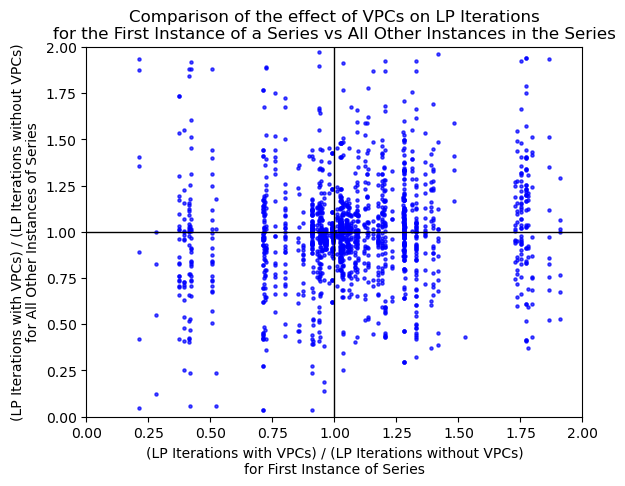

In [71]:
# if cuts helped for the base instance, do they for others?
# set which metric to compare
metric = "iteration"
name_map = {
    "terminationTime": "Running Time",
    "node": "Nodes Processed",
    "iteration": "LP Iterations",
}

# get all unique combinations of instance and perturbation in triples
unique_combinations = triples[['instance', 'perturbation']].drop_duplicates()

# append to each the first instance in the series so we can append their data later
unique_combinations["instanceIndex"] = 0

# get the data for the first instance runs
bound_start_df = df.merge(unique_combinations, on=["instance", "perturbation", "instanceIndex"])[group_cols + id_cols + fields]
data_df = bound_start_df.merge(bound_df, on=group_cols, suffixes=(" Initial", " Test"))

# make a scatter plot of the two metrics with terminationTimeRatio Initial on the x-axis and terminationTimeRatio Test on the y-axis
plt.scatter(data_df[f"{metric}Ratio Initial"], data_df[f"{metric}Ratio Test"],
            marker='o', color='blue', s=5, alpha=.7)
plt.xlabel(f"({name_map[metric]} with VPCs) / ({name_map[metric]} without VPCs)\nfor First Instance of Series")
plt.ylabel(f"({name_map[metric]} with VPCs) / ({name_map[metric]} without VPCs)\nfor All Other Instances of Series")
plt.xlim(0, 2)
plt.ylim(0, 2)   
# add horizontal and vertical lines at 1
plt.axhline(1, color='black', lw=1)
plt.axvline(1, color='black', lw=1)
plt.title(f"Comparison of the effect of VPCs on {name_map[metric]}\nfor the First Instance of a Series vs All Other Instances in the Series")
plt.savefig(os.path.join(out_fldr, f"{metric}_ratio_initial_vs_test.png"))
plt.show()

## Make Profiles

In [69]:
def make_plots(prof_df, metric, show_all=False, perturbation=None, threshold=None):
    
    plt.rc('text', usetex=True)  # use latex fonts

    label = {
        "postRootTime": "Time after Processing Root Node",
        "rootDualBoundTimeSansVpc": "Root Processing Time (Minus VPC Generation)",
        "terminationTimeSansVpc": "Time (Minus VPC Generation)",
        "terminationTime": "Time",
        "nodes": "Nodes Processed",
        "iterations": "LP Iterations",
    }
    unit = {
        "postRootTime": "(seconds)",
        "rootDualBoundTimeSansVpc": "(seconds)",
        "terminationTimeSansVpc": "(seconds)",
        "terminationTime": "(seconds)",
        "nodes": "(1000 nodes)",
        "iterations": "(1000 iterations)",
    }
    
    # Unique values in 'degree' and 'terms'
    unique_degrees = prof_df['degree'].sort_values(ascending=False).unique()  # sort increasing
    unique_terms = prof_df['terms'].sort_values().unique()  # sort decreasing
    
    # Create subplots for a grid
    fig, axes = plt.subplots(len(unique_degrees), len(unique_terms),
                             figsize=(4*len(unique_terms), 4*len(unique_degrees)))
    
    for i, degree in enumerate(unique_degrees):
        for j, terms in enumerate(unique_terms):
            ax = axes[i, j]
    
            # Filter the DataFrame based on 'degree' and 'terms'
            subset_df = prof_df[(prof_df['degree'] == degree) & (prof_df['terms'] == terms)]  
            
            # if we are looking at a specific perturbation, filter for it
            if perturbation is not None:
                subset_df = subset_df[subset_df["perturbation"] == perturbation]
              
            # if we want to filter for a threshold of top % time improvement, do so  
            if threshold is not None:
                cut_off = subset_df["terminationTimeImprovement"].quantile(1 - threshold)
                subset_df = subset_df[subset_df["terminationTimeImprovement"] >= cut_off]
            
            # get our data
            # plug in below to calibrate limits
            # int(prof_df[[f"{metric} Farkas", f"{metric} None"]].max().max())
            limits = {
                "postRootTime": 7200,
                "terminationTimeSansVpc": 7200,
                "terminationTime": 7200,
                "rootDualBoundTimeSansVpc": 5,
                "nodes": 10000,
                "iterations": 50000
            }
            x = range(limits[metric])
            y_farkas = [(subset_df[f"{metric} Farkas"] < i).sum() / len(subset_df) for i in x]        
            y_none = [(subset_df[f"{metric} None"] < i).sum() / len(subset_df) for i in x]
            y_old = [(subset_df[f"{metric} New"] < i).sum() / len(subset_df) for i in x]        
            y_new = [(subset_df[f"{metric} Old"] < i).sum() / len(subset_df) for i in x]
            
            # make our plot
            ax.plot(x, y_none, label="Default")
            if show_all:
                ax.plot(x, y_old, label="Calc Disj, Calc Cuts")
                ax.plot(x, y_new, label="Param Disj, Calc Cuts")
            ax.plot(x, y_farkas, label="Param Disj, Param Cuts")
            
            # Highlight the region where Farkas VPCs have solved more instances than None
            fill_region = np.array([y_farkas[i] > y_none[i] for i in x])
            ax.fill_between(x, y_none, y_farkas, facecolor='yellow', alpha=0.3, where=fill_region, label="Improvement of Param Disj,\nParam Cuts over Default")
            
            # set labels
            if j == 0:
                ax.set_ylabel("Proportion of Instances with\nPrimal-Dual Gap <= 1e-4")
            if i == len(unique_degrees) - 1:
                ax.set_xlabel(label[metric] + " " + unit[metric])
            ax.set_title(f"{degree} Degree{'s' if degree >= 2 else ''} of Perturbation,\n{terms} Disjunctive Terms")
            
            # set y axis
            ax.set_ylim(0.8, 1.05)
    
    
    fig.suptitle(f'{"Number of " if "Time" not in metric else ""}'
                 f'{label[metric]} to Solve Perturbations of MIPLIB3 '
                 f'Instances to Optimality\n'  # (at most 1000 Constraints and Variables'
                 f'{"perturbing only " + perturbation if perturbation else ""}'
                 f'{"(top " + str(int(threshold * 100)) + " percent most improved Param Disj, Param Cuts vs Default)" if threshold else ""}',
                 fontsize=16)

    plt.tight_layout()
    plt.legend()
    plt.savefig(os.path.join(
            out_fldr, f"{metric}{'_'+perturbation if perturbation else ''}.png"
        ), dpi=1200)
    plt.show()

## Make time table

In [70]:
# additional filtering for dataframe on run time
fields = ["terminationTime New", "terminationTime Old",
          "terminationTime Farkas", "terminationTime None",
          "terminationTimeSansVpc New", "terminationTimeSansVpc Old",
          "terminationTimeSansVpc Farkas", "terminationTimeSansVpc None",
          "rootDualBoundTimeSansVpc New", "rootDualBoundTimeSansVpc Old",
          "rootDualBoundTimeSansVpc Farkas", "rootDualBoundTimeSansVpc None",
          "postRootTime New", "postRootTime Old",
          "postRootTime Farkas", "postRootTime None",
          "vpcGenerationTime New", "vpcGenerationTime Old",
          "vpcGenerationTime Farkas", "terminationTimeImprovement"]
# only check perturbed instances that solve to optimality and VPC didn't find optimal solution
mask = mask & (optimality_gap(df, "New") <= 1e-4) & \
       (optimality_gap(df, "None") <= 1e-4) & (optimality_gap(df, "Farkas") <= 1e-4)
time_df = df.loc[mask, group_cols + id_cols + fields]

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = time_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "time.csv"), index=False, mode="w")
out

,degree,terms,terminationTime New,terminationTime Old,terminationTime Farkas,terminationTime None,terminationTimeSansVpc New,terminationTimeSansVpc Old,terminationTimeSansVpc Farkas,terminationTimeSansVpc None,...,postRootTime New,postRootTime Old,postRootTime Farkas,postRootTime None,vpcGenerationTime New,vpcGenerationTime Old,vpcGenerationTime Farkas,terminationTimeImprovement,instance,instanceIndex
0,0.5,4,180.181948,181.305956,9.544156,9.024328,9.123148,9.028731,9.426166,9.024328,...,8.410646,8.318024,8.731166,8.386771,171.058800,172.277225,0.117991,-0.276755,42,747
1,0.5,16,13.279241,13.412987,8.135268,8.340662,8.237031,7.656881,7.872846,8.340662,...,7.690628,7.107753,7.370831,7.704766,5.042210,5.756106,0.262421,-0.553468,37,676
2,0.5,64,26.850610,26.245412,10.739215,8.483361,11.378335,10.525805,10.080249,8.483361,...,11.071718,10.203903,9.765800,8.192873,15.472274,15.719607,0.658966,-1.408994,33,558
3,2.0,4,243.801794,193.417298,10.927059,9.878995,10.405996,10.357683,10.768647,9.878995,...,9.629125,9.620540,10.058097,9.132934,233.395798,183.059615,0.158411,-0.525192,45,645
4,2.0,16,19.091277,18.732130,9.894598,9.090276,8.953248,8.854898,9.440300,9.090276,...,8.393865,8.280493,8.831978,8.366305,10.138029,9.877232,0.454298,-1.250919,39,602
5,2.0,64,39.133261,33.282219,11.088393,8.787612,10.440241,8.849607,10.390022,8.787612,...,10.118325,8.507523,10.055091,8.464930,28.693021,24.432613,0.698371,-1.634156,36,480


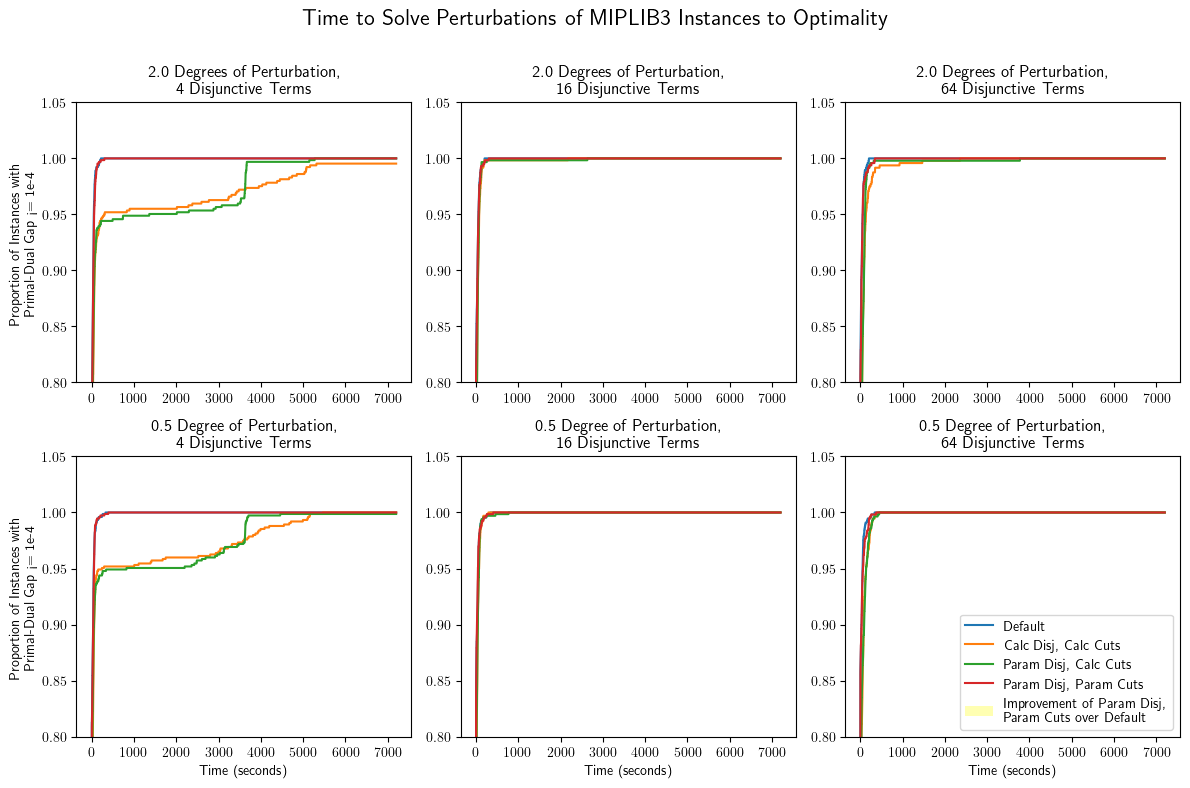

In [72]:
make_plots(time_df, "terminationTime", show_all=True)

# Make node table

In [73]:
# additional filtering for dataframe on nodes processed
fields = ["nodes New", "nodes Old", "nodes Farkas",
          "nodes None", "terminationTimeImprovement"]
node_df = df.loc[mask, group_cols + id_cols + fields]
for f in fields:
    node_df[f] = node_df[f] / 1000

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = node_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "node.csv"), index=False, mode="w")
out

,degree,terms,nodes New,nodes Old,nodes Farkas,nodes None,terminationTimeImprovement,instance,instanceIndex
0,0.5,4,6.183315,6.320501,6.261363,7.095487,-0.000277,42,747
1,0.5,16,8.601751,7.688837,7.790679,8.470420,-0.000553,37,676
2,0.5,64,9.932215,9.037767,8.626269,10.421747,-0.001409,33,558
3,2.0,4,5.641989,5.951291,5.997738,5.566273,-0.000525,45,645
4,2.0,16,8.713500,8.645766,8.259653,9.039944,-0.001251,39,602
5,2.0,64,9.517729,10.423127,10.137096,11.885300,-0.001634,36,480


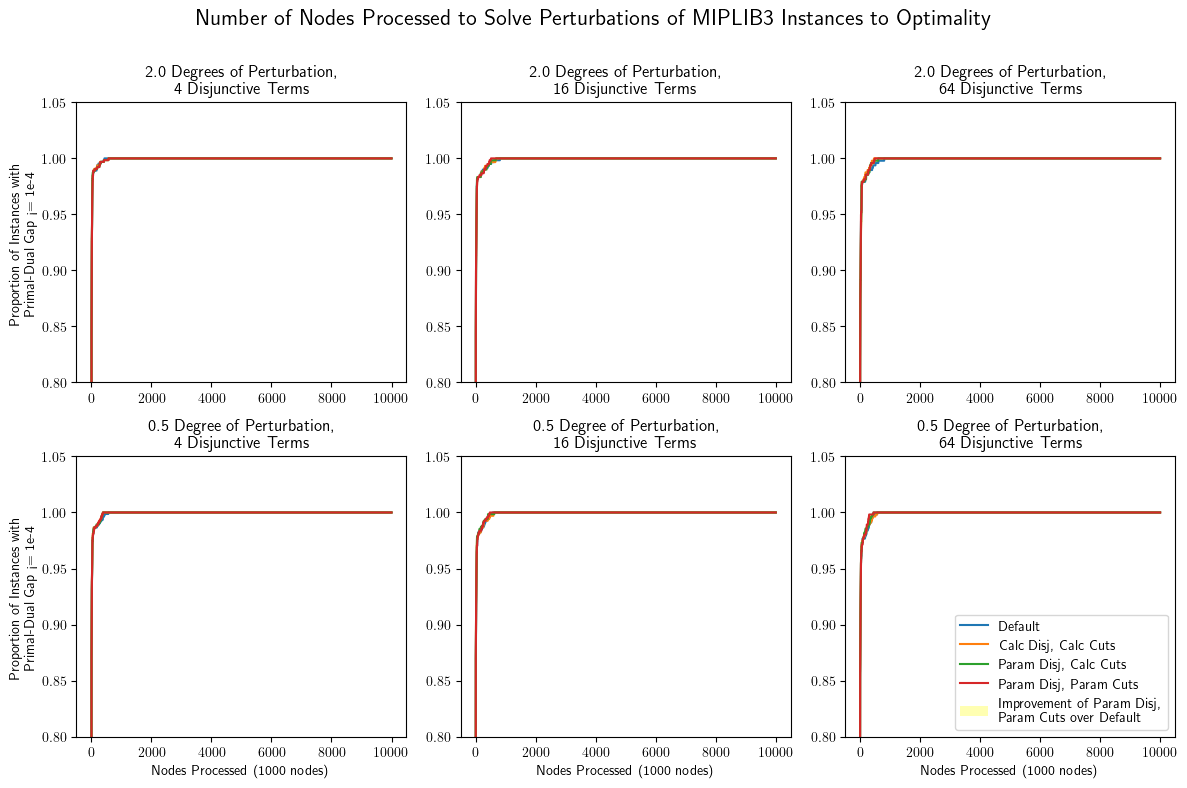

In [74]:
make_plots(node_df, "nodes", show_all=True)

# Make iteration table

In [75]:
# additional filtering for dataframe on nodes processed
fields = ["iterations New", "iterations Old",
          "iterations Farkas", "iterations None",
          "terminationTimeImprovement"]
iteration_df = df.loc[mask, group_cols + id_cols + fields]
for f in fields:
    iteration_df[f] = iteration_df[f] / 1000

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = iteration_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "iteration.csv"), index=False, mode="w")
out

,degree,terms,iterations New,iterations Old,iterations Farkas,iterations None,terminationTimeImprovement,instance,instanceIndex
0,0.5,4,65.672983,66.822083,68.059490,70.458163,-0.000277,42,747
1,0.5,16,74.139001,69.047234,71.934325,74.598268,-0.000553,37,676
2,0.5,64,92.205835,86.476837,85.821801,88.095573,-0.001409,33,558
3,2.0,4,63.547349,66.718225,67.513594,62.283671,-0.000525,45,645
4,2.0,16,74.797304,72.053204,74.353080,75.143312,-0.001251,39,602
5,2.0,64,91.310248,88.620352,90.497437,93.999979,-0.001634,36,480


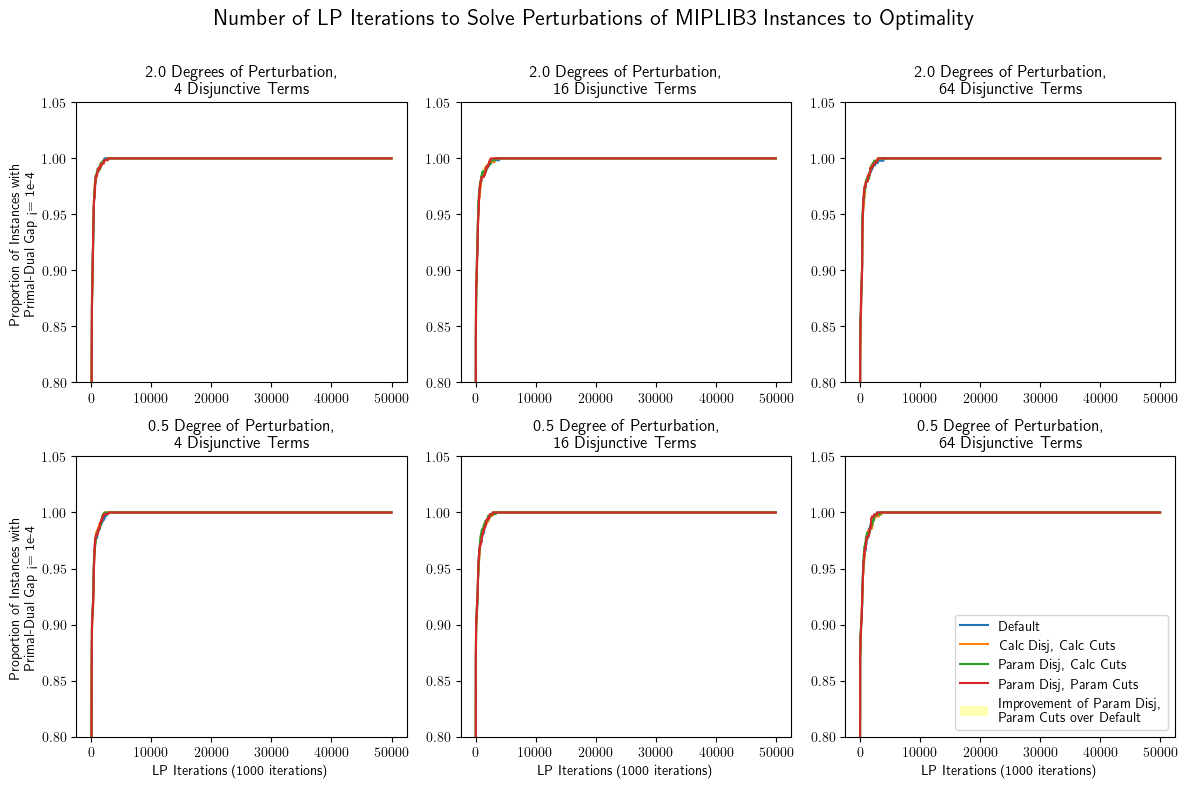

In [76]:
make_plots(iteration_df, "iterations", show_all=True)

## Improvement Consistency

In [77]:
def make_run_time_boxplot(time_df, perturbation=None, threshold=.1):
    plt.rc('text', usetex=True)  # use latex fonts

    # Get unique values of degree and terms
    degrees = time_df['degree'].sort_values(ascending=False).unique()  # sort increasing
    terms = time_df['terms'].sort_values().unique()  # sort decreasing
    
    # Create a grid of subplots
    fig, axes = plt.subplots(len(degrees), len(terms), figsize=(8*len(terms), 4*len(degrees)))
    
    # Iterate through each combination of degree and terms
    for i, degree in enumerate(degrees):
        for j, term in enumerate(terms):
            
            # get the data for this combination
            subset = time_df[(time_df['terms'] == term) &
                             (time_df['degree'] == degree)]
            
            # if we are looking at a specific perturbation, filter for it
            if perturbation is not None:
                subset = subset[subset["perturbation"] == perturbation]
                
            cut_off = subset["terminationTimeImprovement"].quantile(1 - threshold)
            
            # now break it down by instance
            unique_instances = subset['instance'].sort_values().unique()
            instance_data = [subset[subset['instance'] == instance]['terminationTimeImprovement'].tolist()
                             for instance in unique_instances]
            
            # make all the boxplots for this plot
            axes[i, j].boxplot(instance_data, labels=unique_instances)
            axes[i, j].axhline(cut_off, color='black', linestyle='--', linewidth=1, alpha=.5, label=f"Top {int(threshold * 100)} Percent of Instances")
            axes[i, j].set_ylim(-3, 1)
            axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), rotation=90)
            axes[i, j].set_title(f"{degree} Degree{'s' if degree >= 2 else ''} "
                                 f"of Perturbation,\n{term} Disjunctive Terms")
            if j == 0:
                axes[i, j].set_ylabel('Relative Time Improvement\n'
                                      '(Param Disj, Param Cuts vs Default)')
            if i == len(degrees) - 1:
                axes[i, j].set_xlabel('Instance')
    
    fig.suptitle(f"Distributions of Relative Time Improvement for Param Disj, "
                 f"Param Cuts compared to Default"
                 f"{' - perturbing only ' + perturbation if perturbation else ''}\n"
                 f"(positive values imply Param Disj, Param Cuts'"
                 f" run time faster than Default's)", fontsize=16)
    
    plt.tight_layout()
    plt.savefig(os.path.join(out_fldr, f"time_improvement_distribution"
                                       f"{'_' + perturbation if perturbation else ''}.png"),
                dpi=1200)
    plt.legend()
    plt.show()

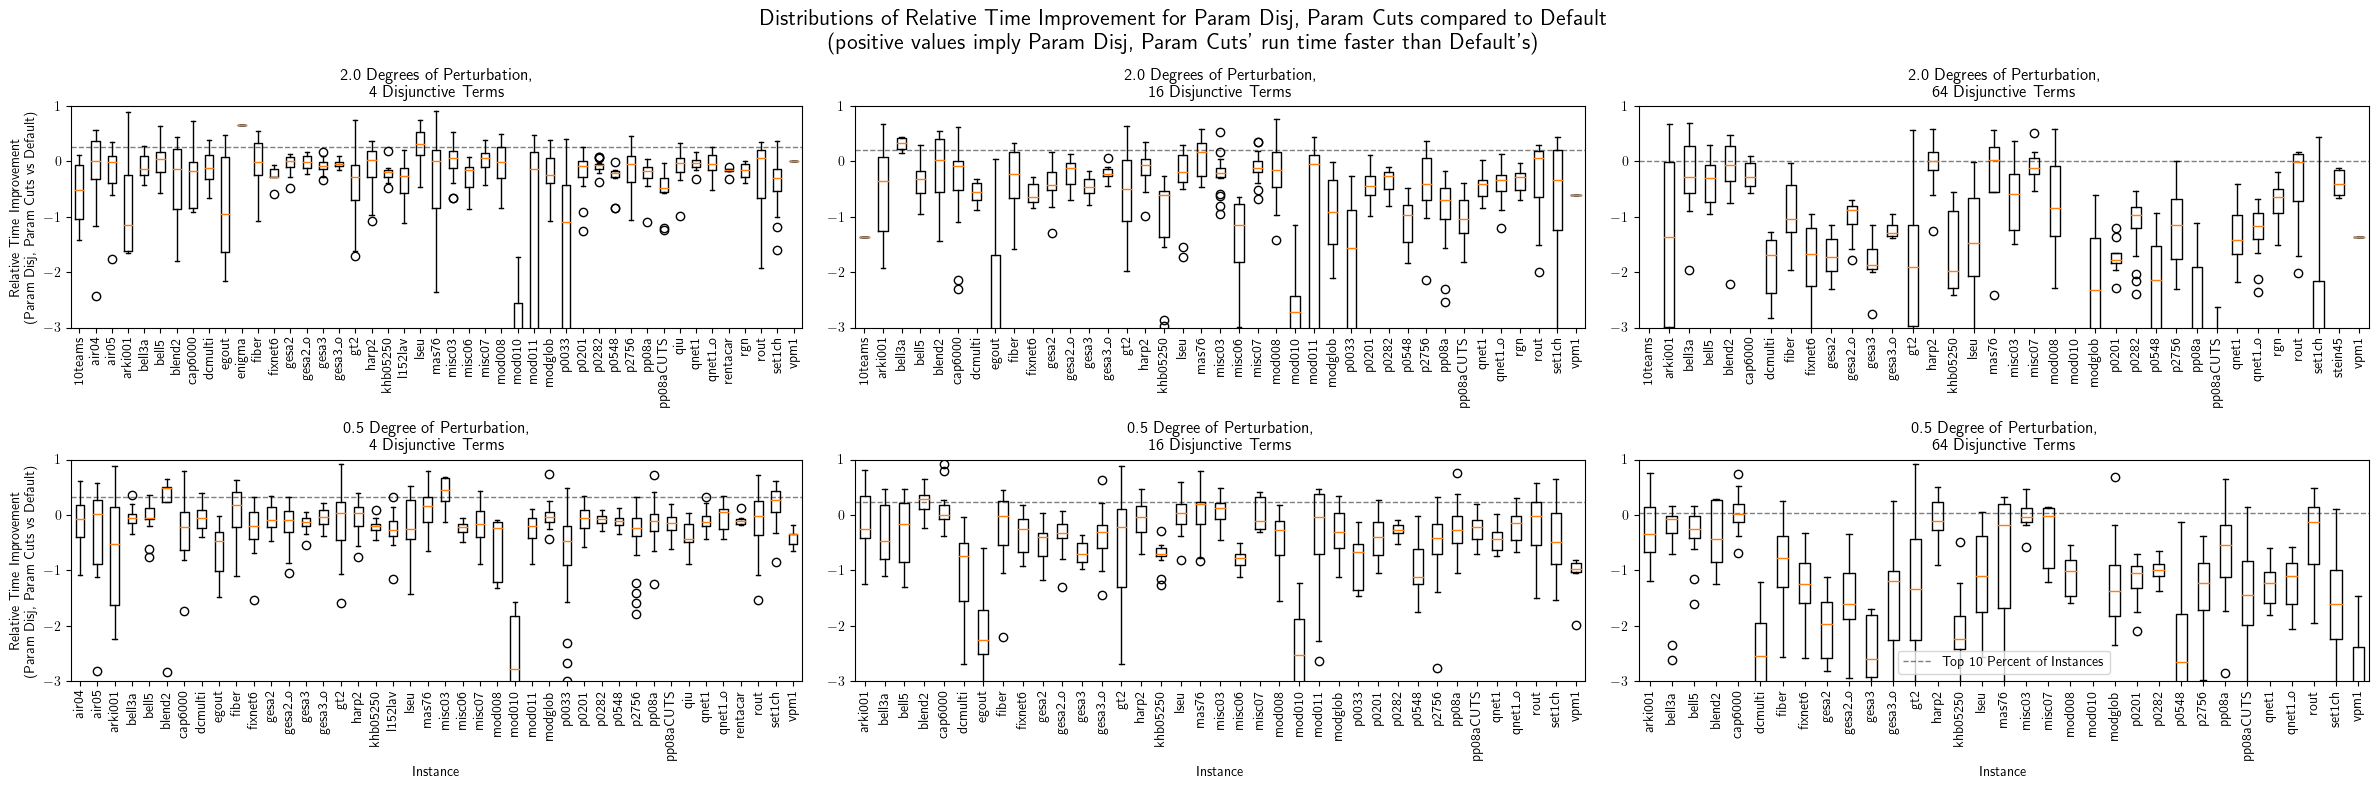

In [78]:
make_run_time_boxplot(time_df)

In [79]:
# get a table of all unperturbed instances that solved to optimality
df_zero = df_map["None"].loc[(df_map["None"]["instanceIndex"] == 0) & (optimality_gap(df_map["None"]) <= 1e-4)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


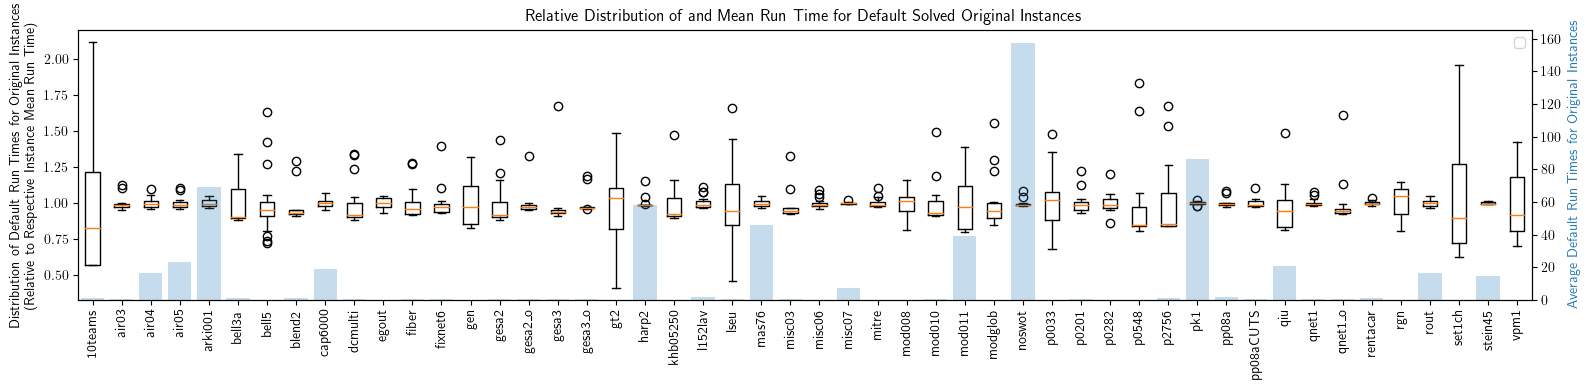

In [80]:
# configure plot
plt.rc('text', usetex=True)
fig, ax1 = plt.subplots(figsize=(16, 4))

# now break it down by instance
mean_run = df_zero.groupby("instance")["terminationTime"].mean().to_dict()
data = {instance: df_zero[df_zero['instance'] == instance]['terminationTime'].values / time
         for instance, time in mean_run.items()}

# make all the boxplots for this plot
ax1.boxplot(data.values(), labels=data.keys())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_ylabel('Distribution of Default Run Times for Original Instances\n'
               '(Relative to Respective Instance Mean Run Time)')
ax1.set_title("Relative Distribution of and Mean Run Time for Default Solved Original Instances")

# make the barchart for this plot
ax2 = ax1.twinx()
color = 'tab:blue'
plt.bar(np.arange(1, len(mean_run) + 1), mean_run.values(), alpha=.25, color=color)
ax2.set_ylabel('Average Default Run Times for Original Instances', color=color)

plt.tight_layout()
plt.savefig(os.path.join(out_fldr, "original_distribution.png"), dpi=1200)
plt.legend()
plt.show()

## Check Root Optimality Gap Relationships

In [81]:
gap_df = df.loc[mask]  # & (df["terms"] == 64) & (df["degree"] == .5)]

In [82]:
gap_df.columns

Index(['instanceIndex', 'vpcGenerator None', 'terms', 'lpBound None',
       'disjunctiveDualBound None', 'lpBoundPostVpc None',
       'rootDualBound None', 'dualBound None', 'primalBound None',
       'vpcGenerationTime None',
       ...
       'postRootTime None', 'postRootTime New', 'postRootTime Old',
       'postRootTime Farkas', 'terminationTimeImprovement', 'nodeImprovement',
       'iterationImprovement', 'terminationTimeRatio', 'nodeRatio',
       'iterationRatio'],
      dtype='object', length=109)

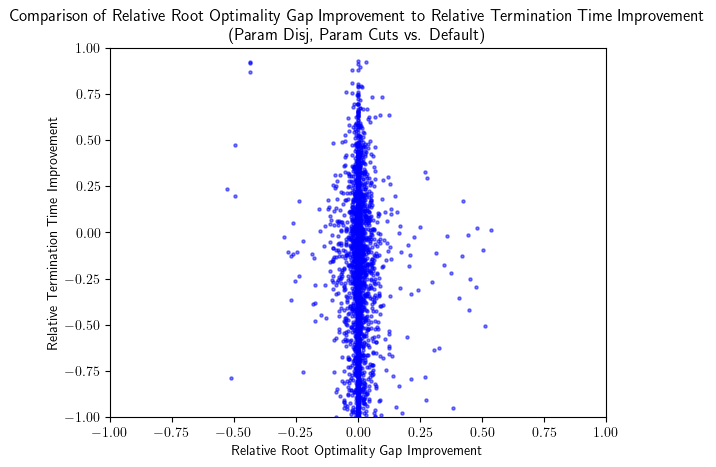

In [83]:
plt.scatter(gap_df["Root Optimality Gap Improvement"], gap_df["terminationTimeImprovement"],
            marker='o', color='blue', s=5, alpha=0.5)
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.title("Comparison of Relative Root Optimality Gap Improvement to Relative Termination Time Improvement\n"
          "(Param Disj, Param Cuts vs. Default)")
plt.xlabel("Relative Root Optimality Gap Improvement")
plt.ylabel("Relative Termination Time Improvement")
plt.savefig(os.path.join(out_fldr, "gap_vs_time.png"), dpi=1200)
plt.show()

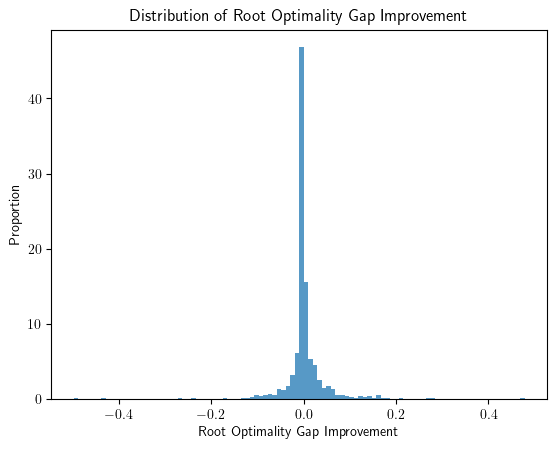

In [84]:
# Create a histogram with 100 bins
plt.hist(gap_df.loc[(-.5 < gap_df["Root Optimality Gap Improvement"]) & (gap_df["Root Optimality Gap Improvement"] < .5),
                    "Root Optimality Gap Improvement"], bins=100, density=True, alpha=0.75)

# Add labels and a title
plt.xlabel('Root Optimality Gap Improvement')
plt.ylabel('Proportion')
plt.title('Distribution of Root Optimality Gap Improvement')

# Display the plot
plt.show()

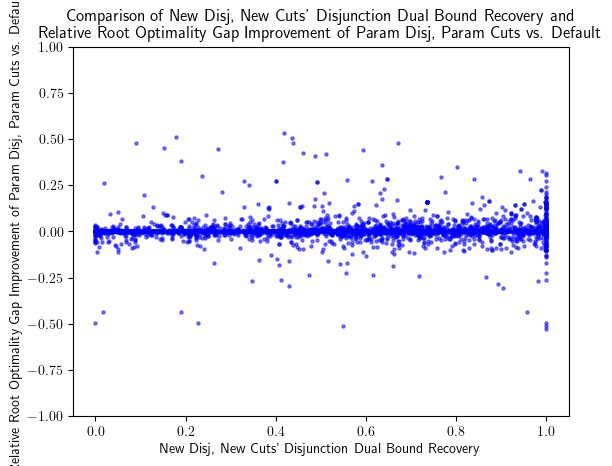

In [85]:
# is there a relationship between how much of dual bound we recover and root optimality gap improvement
plt.scatter(gap_df["VPCs (New)"] / gap_df["Disjunction (New)"],
            gap_df["Root Optimality Gap Improvement"],
            marker='o', color='blue', s=5, alpha=0.5)
plt.ylim(-1, 1)
plt.title("Comparison of New Disj, New Cuts' Disjunction Dual Bound Recovery and\n"
          "Relative Root Optimality Gap Improvement of Param Disj, Param Cuts vs. Default")
plt.xlabel("New Disj, New Cuts' Disjunction Dual Bound Recovery")
plt.ylabel("Relative Root Optimality Gap Improvement of Param Disj, Param Cuts vs. Default")
plt.show()

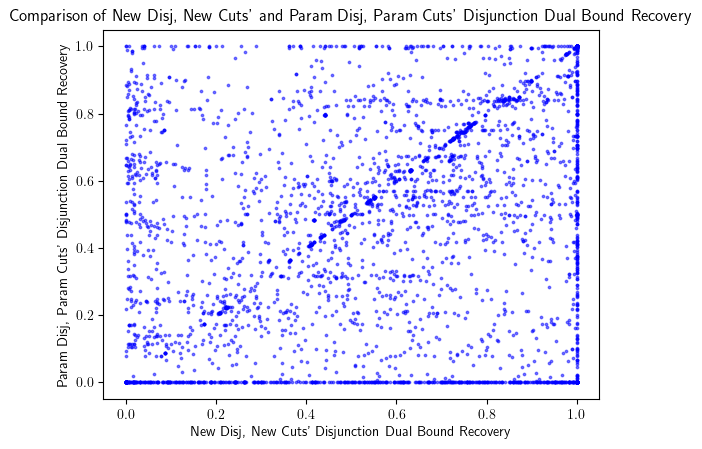

In [86]:
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["VPCs (New)"] / gap_df["Disjunction (New)"],
            gap_df["VPCs (Farkas)"] / gap_df["Disjunction (Old)"],
            marker='o', color='blue', s=3, alpha=0.5)
plt.title("Comparison of New Disj, New Cuts' and Param Disj, Param Cuts' Disjunction Dual Bound Recovery")
plt.xlabel("New Disj, New Cuts' Disjunction Dual Bound Recovery")
plt.ylabel("Param Disj, Param Cuts' Disjunction Dual Bound Recovery")
plt.show()  # todo: what happens when Param Disj, Param Cuts recovers the same amount of dual bound?

In [87]:
df.columns

Index(['instanceIndex', 'vpcGenerator None', 'terms', 'lpBound None',
       'disjunctiveDualBound None', 'lpBoundPostVpc None',
       'rootDualBound None', 'dualBound None', 'primalBound None',
       'vpcGenerationTime None',
       ...
       'postRootTime None', 'postRootTime New', 'postRootTime Old',
       'postRootTime Farkas', 'terminationTimeImprovement', 'nodeImprovement',
       'iterationImprovement', 'terminationTimeRatio', 'nodeRatio',
       'iterationRatio'],
      dtype='object', length=109)

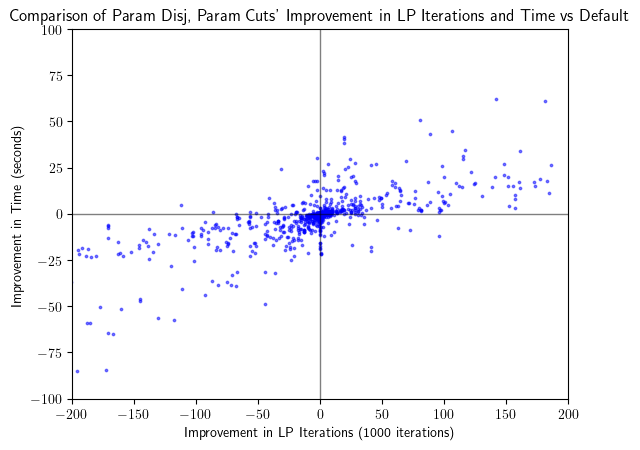

In [88]:
# plot iteration improvement over termination time improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["iterations None"]/1000 - gap_df["iterations Farkas"]/1000,
            gap_df["terminationTime None"] - gap_df["terminationTime Farkas"],
            marker='o', color='blue', s=3, alpha=0.5)
plt.xlim(-200, 200)
plt.ylim(-100, 100)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Comparison of Param Disj, Param Cuts' Improvement in LP Iterations and Time vs Default")
plt.xlabel("Improvement in LP Iterations (1000 iterations)")
plt.ylabel("Improvement in Time (seconds)")
plt.savefig(os.path.join(out_fldr, "lp_iters_vs_time.png"), dpi=1200)
plt.show()

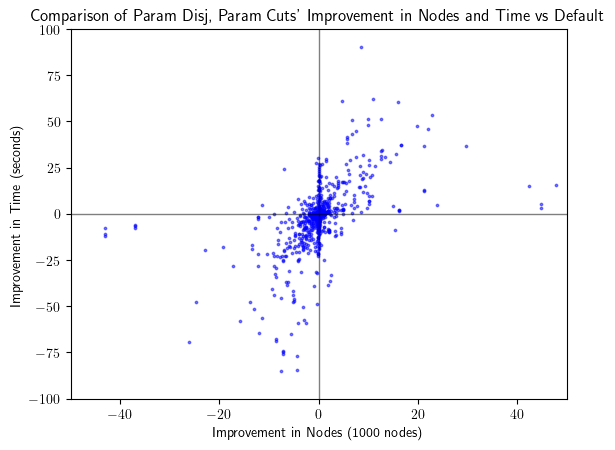

In [89]:
# plot iteration improvement over termination time improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["nodes None"]/1000 - gap_df["nodes Farkas"]/1000,
            gap_df["terminationTime None"] - gap_df["terminationTime Farkas"],
            marker='o', color='blue', s=3, alpha=0.5)
plt.xlim(-50, 50)
plt.ylim(-100, 100)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Comparison of Param Disj, Param Cuts' Improvement in Nodes and Time vs Default")
plt.xlabel("Improvement in Nodes (1000 nodes)")
plt.ylabel("Improvement in Time (seconds)")
plt.savefig(os.path.join(out_fldr, "nodes_vs_time.png"), dpi=1200)
plt.show()

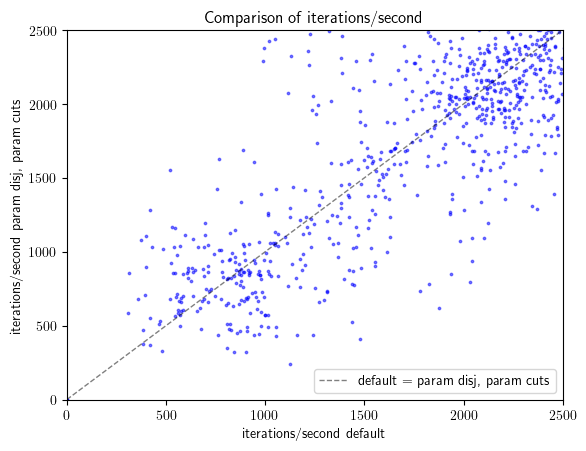

In [90]:
# plot iteration improvement over termination time improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["iterations Farkas"]/gap_df["terminationTimeSansVpc Farkas"],
            gap_df["iterations None"]/gap_df["terminationTimeSansVpc None"],
            marker='o', color='blue', s=3, alpha=0.5)
# plot the line y = x
x = np.linspace(0, 3000, 3000)
plt.plot(x, x, linestyle='--', color='black', linewidth=1, alpha=.5,
         label="default = param disj, param cuts")
plt.xlim(0, 2500)
plt.ylim(0, 2500)
plt.title("Comparison of iterations/second")
plt.xlabel("iterations/second default")
plt.ylabel("iterations/second param disj, param cuts")
plt.legend()
plt.savefig(os.path.join(out_fldr, "lp_iters_per_second.png"), dpi=1200)
plt.show()

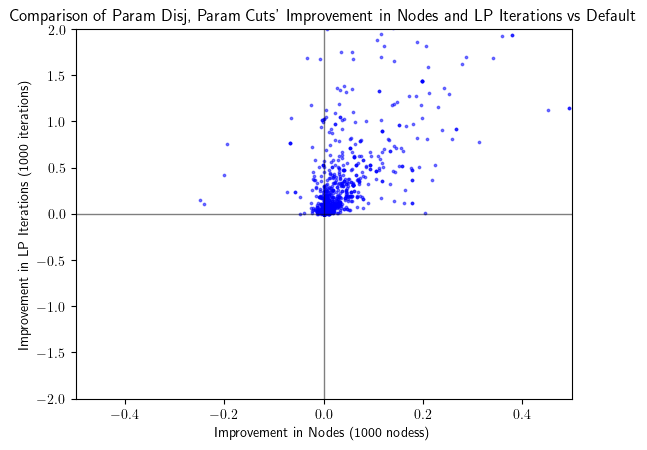

In [91]:
# plot node improvement over iteration improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
tdf = gap_df.loc[(gap_df["iterationImprovement"] > 0) & (gap_df["terminationTimeImprovement"] < 0)]
plt.scatter(tdf["nodes None"]/1000 - tdf["nodes Farkas"]/1000,
            tdf["iterations None"]/1000 - tdf["iterations Farkas"]/1000,
            marker='o', color='blue', s=3, alpha=0.5)
plt.xlim(-.5, .5)
plt.ylim(-2, 2)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Comparison of Param Disj, Param Cuts' Improvement in Nodes and LP Iterations vs Default")
plt.xlabel("Improvement in Nodes (1000 nodess)")
plt.ylabel("Improvement in LP Iterations (1000 iterations)")
plt.savefig(os.path.join(out_fldr, "nodes_vs_lp_iters_werid.png"), dpi=1200)
plt.show()

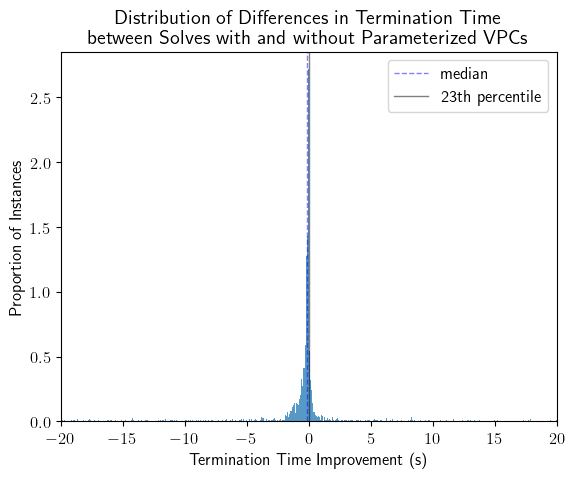

In [92]:
plt.rc('text', usetex=True)
plt.rcParams['font.size'] = 12

# Create a histogram with 600 bins
plt.hist(gap_df["terminationTime None"] - gap_df["terminationTime Farkas"],
         bins=14400, density=True, alpha=0.75)
plt.xlim(-20, 20)

cut_off = (gap_df["terminationTime None"] - gap_df["terminationTime Farkas"]).quantile(.5)
zeroth_percentile = int(100 * round((gap_df["terminationTime None"] >= gap_df["terminationTime Farkas"]).sum() / len(gap_df), 2))
plt.axvline(cut_off, color='blue', linestyle='--', linewidth=1, alpha=.5, label=f"median")
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5, label=f"{zeroth_percentile}th percentile")

# Add labels and a title
plt.xlabel('Termination Time Improvement (s)')
plt.ylabel('Proportion of Instances')
plt.title('Distribution of Differences in Termination Time\nbetween Solves with and without Parameterized VPCs')

# Display the plot
plt.legend()
plt.savefig(os.path.join(out_fldr, "time_improvement_distribution.png"), dpi=1200)
plt.show()

In [93]:
gap_df

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,postRootTime None,postRootTime New,postRootTime Old,postRootTime Farkas,terminationTimeImprovement,nodeImprovement,iterationImprovement,terminationTimeRatio,nodeRatio,iterationRatio
1,1,None,64,2.834221e+02,2.834221e+02,2.834221e+02,2.956508e+02,3.070000e+02,3.070000e+02,0.000002,...,0.736998,0.262970,1.027430,0.856914,-0.338069,0.572060,0.608390,1.338069,0.427940,0.391610
2,2,None,64,2.987642e+02,2.987642e+02,2.987642e+02,3.082834e+02,3.110000e+02,3.110000e+02,0.000003,...,0.125197,0.039321,0.015842,0.032192,-0.087312,0.795556,0.215302,1.087312,0.204444,0.784698
3,3,None,64,2.987642e+02,2.987642e+02,2.987642e+02,3.082834e+02,3.110000e+02,3.110000e+02,0.000002,...,0.125456,0.037846,0.015691,0.032542,-0.086810,0.795556,0.215302,1.086810,0.204444,0.784698
4,4,None,64,2.834221e+02,2.834221e+02,2.834221e+02,2.956508e+02,3.070000e+02,3.070000e+02,0.000003,...,0.817158,0.278410,1.008325,0.717395,-0.061528,0.572060,0.608390,1.061528,0.427940,0.391610
6,1,None,16,2.017035e+05,2.017035e+05,2.017035e+05,3.898140e+05,4.079416e+05,4.079416e+05,0.000002,...,0.293982,0.289242,0.241408,0.233160,-0.329396,0.267045,0.239175,1.329396,0.732955,0.760825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4275,2,None,16,-2.369201e+06,-2.369201e+06,-2.369201e+06,-2.293572e+06,-2.293562e+06,-2.293344e+06,0.000002,...,3.131531,3.023139,2.961437,2.885036,-0.108004,0.367211,0.279698,1.108004,0.632789,0.720302
4276,3,None,16,-2.401510e+06,-2.401510e+06,-2.401510e+06,-2.353894e+06,-2.353885e+06,-2.353766e+06,0.000002,...,50.645165,9.308348,9.769085,9.483880,0.789483,0.711921,0.657385,0.210517,0.288079,0.342615
4277,4,None,16,-2.442574e+06,-2.442574e+06,-2.442574e+06,-2.417060e+06,-2.417036e+06,-2.416840e+06,0.000003,...,35.697537,35.546116,35.806227,35.580637,-0.009378,0.006051,0.045040,1.009378,0.993949,0.954960
4279,1,None,64,9.592934e+07,9.592934e+07,9.592934e+07,1.092827e+08,1.092827e+08,1.092827e+08,0.000002,...,0.002065,0.002183,0.002203,0.002190,-4.109377,0.000000,-0.033520,5.109377,1.000000,1.033520


## See Where My Work Went off the Rails

In [94]:
# create a table to compare unperturbed instances with aleks' results for them
groups = ["instance", "terms"]
fields = ["lpBound New", "disjunctiveDualBound New", "lpBoundPostVpc New", "rootDualBound None",
          "rootDualBound New", "primalBound None", "terminationTime None", "Root Cuts (New)", "Root Cuts (None)"]
comp = df.loc[df["instanceIndex"] == 0, groups + fields].groupby(groups).mean().reset_index()
comp.to_csv(os.path.join(out_fldr, "unperturbed_bound_table.csv"), index=False, mode="w")
comp

,instance,terms,lpBound New,disjunctiveDualBound New,lpBoundPostVpc New,rootDualBound None,rootDualBound New,primalBound None,terminationTime None,Root Cuts (New),Root Cuts (None)
0,10teams,4,9.170000e+02,9.170000e+02,9.170000e+02,9.240000e+02,9.240000e+02,924.0,1.188965,1.000000,1.000000
1,22433,4,2.124053e+04,2.137786e+04,2.136476e+04,2.139647e+04,2.141363e+04,21477.0,0.372869,0.732027,0.659438
2,23588,4,7.649866e+03,7.799913e+03,7.770875e+03,7.770368e+03,7.790990e+03,8090.0,1.689304,0.320639,0.273784
3,23588,16,7.649866e+03,7.867861e+03,7.860396e+03,7.770368e+03,7.863309e+03,8090.0,1.694107,0.484950,0.273784
4,23588,64,7.649866e+03,7.967565e+03,7.965182e+03,7.770368e+03,7.965444e+03,8090.0,1.736420,0.717004,0.273784
...,...,...,...,...,...,...,...,...,...,...,...
452,traininstance6,4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,28290.0,5.823154,0.000000,0.000000
453,traininstance6,16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,28290.0,5.616142,0.000000,0.000000
454,uct-subprob,4,2.420000e+02,2.426667e+02,2.426667e+02,2.777899e+02,2.770091e+02,314.0,3600.004987,0.486237,0.497083
455,uct-subprob,64,2.420000e+02,2.453613e+02,2.450029e+02,2.777899e+02,2.771599e+02,314.0,3600.005915,0.488332,0.497083


In [95]:
# create a table with aleks's results for the unperturbed instances 
adf = pd.read_csv("aleks_results.csv")
adf = adf[["INSTANCE", "disj_terms", "LP OBJ", "BEST DISJ OBJ", "VPC OBJ", "AVG REF LAST_CUT_PASS", "AVG REF+V LAST_CUT_PASS", "ip_obj", "BEST REF TIME"]]
adf["rcnew"] = abs(adf["AVG REF+V LAST_CUT_PASS"] - adf["LP OBJ"]) / abs(adf["ip_obj"] - adf["LP OBJ"]) 
adf["rcnone"] = abs(adf["AVG REF LAST_CUT_PASS"] - adf["LP OBJ"]) / abs(adf["ip_obj"] - adf["LP OBJ"])
adf.columns = groups + fields
adf['instance'] = adf['instance'].str.replace('_presolved', '')
adf['instance'] = adf['instance'].str.replace('mas0', 'mas')
adf = adf.loc[(0 <= adf["Root Cuts (New)"]) & (adf["Root Cuts (New)"] <= 1)]

In [96]:
# join comp and adf on instance and terms to get a comparison of the two and see what's missing
keep_cols = groups + ["Root Cuts (New)", "Root Cuts (None)", "terminationTime None"]
both = comp[keep_cols].merge(adf[keep_cols], on=groups, suffixes=(" sean", " aleks"), how="outer")
both

,instance,terms,Root Cuts (New) sean,Root Cuts (None) sean,terminationTime None sean,Root Cuts (New) aleks,Root Cuts (None) aleks,terminationTime None aleks
0,10teams,4.0,1.000000,1.000000,1.188965,1.000000,1.000000,0.301
1,22433,4.0,0.732027,0.659438,0.372869,0.675821,0.667379,0.093
2,23588,4.0,0.320639,0.273784,1.689304,0.318880,0.243813,0.420
3,23588,16.0,0.484950,0.273784,1.694107,0.487854,0.243813,0.424
4,23588,64.0,0.717004,0.273784,1.736420,0.717759,0.243813,0.421
...,...,...,...,...,...,...,...,...
2099,umts,64.0,NaN,NaN,NaN,0.049433,0.047454,49.839
2100,usAbbrv-8-25_70,64.0,NaN,NaN,NaN,0.000000,0.000000,3600.000
2101,vpm1,64.0,NaN,NaN,NaN,0.721295,0.681575,0.004
2102,vpm2,64.0,NaN,NaN,NaN,0.719205,0.718862,0.098


In [97]:
# make a dataframe that compares the experiments we both ran
diff = both.loc[~pd.isna(both["Root Cuts (New) sean"]) & ~pd.isna(both["Root Cuts (New) aleks"])]
diff["improvement aleks"] = (diff["Root Cuts (New) aleks"] - diff["Root Cuts (None) aleks"]) / diff["Root Cuts (None) aleks"]

# get some summary stats - looks like we are pretty close
# I expect the difference is that I'm not adding GMICs and I'm using different sized disjunctions 
diff[diff.columns[2:]].mean()

/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_98707/3402183073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff["improvement aleks"] = (diff["Root Cuts (New) aleks"] - diff["Root Cuts (None) aleks"]) / diff["Root Cuts (None) aleks"]


Root Cuts (New) sean            0.563515
Root Cuts (None) sean           0.557052
terminationTime None sean     638.246386
Root Cuts (New) aleks           0.536687
Root Cuts (None) aleks          0.523029
terminationTime None aleks    314.799813
improvement aleks                    inf
dtype: float64

In [98]:
# let's examine the instances for which I don't have data
mdf = both.loc[(both["Root Cuts (None) sean"].isna()) & (both["terms"].isin([4, 16, 64])),
               ["instance", "terms", "Root Cuts (New) aleks", "Root Cuts (None) aleks", "terminationTime None aleks"]]
mdf.columns = ["instance", "terms", "Root Cuts (New)", "Root Cuts (None)", "terminationTime None"]
mdf["improvement"] = (mdf["Root Cuts (New)"] - mdf["Root Cuts (None)"]) / mdf["Root Cuts (None)"]
mdf

,instance,terms,Root Cuts (New),Root Cuts (None),terminationTime None,improvement
80,decomp1,16.0,NaN,NaN,NaN,NaN
81,decomp1,64.0,NaN,NaN,NaN,NaN
423,shipschedule3shipsi,4.0,NaN,NaN,NaN,NaN
424,shipschedule3shipsi,16.0,NaN,NaN,NaN,NaN
425,shipschedule6shipsmixi,4.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2099,umts,64.0,0.049433,0.047454,49.839,0.041720
2100,usAbbrv-8-25_70,64.0,0.000000,0.000000,3600.000,NaN
2101,vpm1,64.0,0.721295,0.681575,0.004,0.058276
2102,vpm2,64.0,0.719205,0.718862,0.098,0.000477


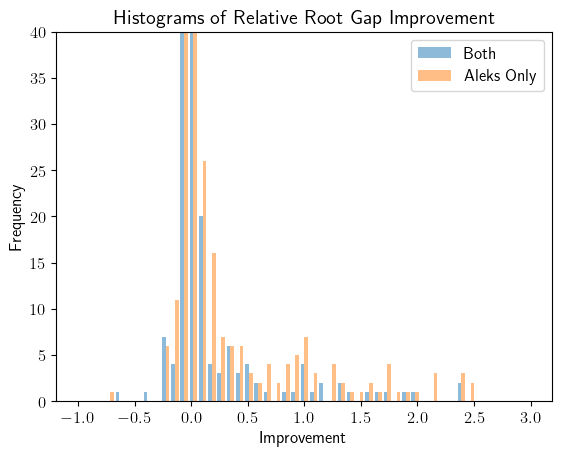

In [99]:
# Plot histograms
plt.hist([diff["improvement aleks"], mdf["improvement"]], bins=np.linspace(-1, 3, 50), alpha=0.5, label=['Both', 'Aleks Only'])

plt.ylim(0, 40)

# Add labels and title
plt.xlabel('Improvement')
plt.ylabel('Frequency')
plt.title('Histograms of Relative Root Gap Improvement')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [100]:
# set the index of mdf to the combination of instance and terms
mdf = mdf.set_index(["instance", "terms"])
mdf

Root Cuts (New)  Root Cuts (None)  \
instance               terms                                      
decomp1                16.0               NaN               NaN   
                       64.0               NaN               NaN   
shipschedule3shipsi    4.0                NaN               NaN   
                       16.0               NaN               NaN   
shipschedule6shipsmixi 4.0                NaN               NaN   
...                                       ...               ...   
umts                   64.0          0.049433          0.047454   
usAbbrv-8-25_70        64.0          0.000000          0.000000   
vpm1                   64.0          0.721295          0.681575   
vpm2                   64.0          0.719205          0.718862   
zib54-UUE              64.0          0.681297          0.687208   

                              terminationTime None  improvement  
instance               terms                                     
decomp1                16.0                    NaN          NaN  
                       64.0                    NaN          NaN  
shipschedule3shipsi    4.0                     NaN          NaN  
                       16.0                    NaN          NaN  
shipschedule6shipsmixi 4.0                     NaN          NaN  
...                                            ...          ...  
umts                   64.0                 49.839     0.041720  
usAbbrv-8-25_70        64.0               3600.000          NaN  
vpm1                   64.0                  0.004     0.058276  
vpm2                   64.0                  0.098     0.000477  
zib54-UUE              64.0                103.298    -0.008602  

[620 rows x 4 columns]

In [101]:
# classify missing experiment data by excluded instance (either aleks' mislabeled or I just missed), max run time, unperturbable, or run time error
mdf["reason"] = "unknown"

# read in list of dropped instances from aleks' data set
# i think the issue is some aleks tested despite saying he wasn't and others were more than 5k x 5k rows but preprocess to less
dropped = pd.read_csv("dropped.csv", index_col="instance")

for (instance, terms) in mdf.index:
    cur_inst_test_set_fldr = os.path.join(test_set_fldr, instance)
    if instance + ".mps" not in os.listdir(instance_fldr):
        if instance in dropped.index:
            mdf.loc[(instance, terms), "reason"] = "dropped"  # excluded by vpc
        else:
            mdf.loc[(instance, terms), "reason"] = "missed"  # not run yet
    elif mdf.loc[(instance, terms), "terminationTime None"] > 3599:
        mdf.loc[(instance, terms), "reason"] = "max run time"  # hit the max run time
    elif not os.path.exists(cur_inst_test_set_fldr) or not os.listdir(cur_inst_test_set_fldr):
        mdf.loc[(instance, terms), "reason"] = "unperturbable"  # weren't able to perturb
    else:
        mdf.loc[(instance, terms), "reason"] = "runtime error"  # crashed or ran within 1 hour but no results data

In [102]:
# summary stats on where our improving runs are hiding
stats = mdf.groupby("reason").agg({'Root Cuts (New)': 'mean', 'Root Cuts (None)': 'mean', 'improvement': 'count'}).reset_index()
stats.rename(columns={"improvement": "count"}, inplace=True)
stats["weighted improvement"] = (stats["Root Cuts (New)"] - stats["Root Cuts (None)"]) * stats["count"]
stats["weighted improvement"] = (stats["weighted improvement"] / stats["weighted improvement"].sum()).round(4)
stats.sort_values("weighted improvement", ascending=False)

,reason,Root Cuts (New),Root Cuts (None),count,weighted improvement
2,missed,0.498358,0.450770,300,0.5586
0,dropped,0.738627,0.621918,48,0.2192
3,runtime error,0.383373,0.329777,103,0.2160
1,max run time,0.263375,0.261202,56,0.0048
4,unperturbable,0.523079,0.521500,23,0.0014


In [103]:
# track down the experiments we excluded because we missed creating them
# stein9 is an outlier pushing things up
missing = mdf[mdf["reason"] == "missed"]
missing

,,Root Cuts (New),Root Cuts (None),terminationTime None,improvement,reason
instance,terms,,,,,
bc,4.0,0.302212,0.302552,35.878,-0.001122,missed
bc1,4.0,0.427863,0.448678,6.347,-0.046393,missed
bell3a,4.0,0.478648,0.478648,0.214,0.000000,missed
bell3b,4.0,0.901596,0.491740,0.121,0.833481,missed
bell5,4.0,0.284498,0.294200,0.038,-0.032977,missed
...,...,...,...,...,...,...
stein45_nocard,64.0,0.590909,0.263384,3.653,1.243528,missed
tanglegram2,64.0,1.000000,0.980850,0.047,0.019524,missed
timtab2,64.0,0.480566,0.476907,3600.000,0.007673,missed


In [104]:
# let's look at what aleks "missed"
aleks_missing = both.loc[pd.isna(both["Root Cuts (New) aleks"])].drop_duplicates("instance").sort_values("instance")
aleks_missing["row"], aleks_missing["col"], aleks_missing["source"] = 0, 0, "unknown"
aleks_missing.set_index("instance", inplace=True)

# get problem size
for instance in aleks_missing.index:
    aleks_missing.loc[instance, "row"] = rows.get(instance, 0)
    aleks_missing.loc[instance, "col"] = cols.get(instance, 0)
    
# get source of instance
for instance in aleks_missing.index:
    for fldr in os.listdir("../../"):
        if not os.path.isdir(f"../../{fldr}"):
            continue
        if instance + ".mps" in os.listdir(f"../../{fldr}") or instance + ".mps.gz" in os.listdir(f"../../{fldr}"):
            aleks_missing.loc[instance, "source"] = fldr

# trim down to what we want - looks like mas misnamed but otherwise we are good
aleks_missing = aleks_missing[["row", "col", "source"]]
aleks_missing

,row,col,source
instance,,,
app2-2,335,1226,miplib2017
arki001,1048,1388,miplib3
beavma,372,390,miplib2017
ci-s4,26159,745,miplib2017
decomp1,8357,10735,miplib2017
f2gap401600,40,1600,miplib2017
f2gap801600,80,1600,miplib2017
gen-ip054,27,30,miplib2017
haprp,1048,1828,miplib2017


In [106]:
# now lets track down which error modes are sinking us most
run_error = mdf[mdf["reason"] == "runtime error"]

# collect the ways each instance/term combination fails
err_map = []

# iterate over instances and terms of aleks' tests we're missing because of run errors
for instance, terms in run_error.index:
    terms = int(terms)
    found_err = False
    
    # iterate over our error modes to find matches
    for mode, failed_experiments in err.items():
        for failed_experiment in failed_experiments:
            if f"{instance}_" in failed_experiment and f"_{terms}_" in failed_experiment:
                
                # if we find a match, see if we can get a more specific error mode
                sub_mode = mode
                if sub_mode == "no vpcs were made from a new disjunction":
                    sub_mode = [vpc_err_mode for vpc_err_mode, vpc_err_exps in vpc_err.items()
                            if failed_experiment in vpc_err_exps].pop()
                
                # append the mode
                err_map.append({
                    "instance": instance,
                    "terms": float(terms),
                    "mode": sub_mode,
                    "experiment": failed_experiment,
                    "experiment group": "_".join(failed_experiment.split("_")[:-1]),
                    "cut type": failed_experiment.split("_")[-1]
                })
                found_err = True
                
    # do the same thing as the above for all other termination modes
    misc = {"other": other, "warning": warning, "empty": empty}
    for mode, failed_experiments in misc.items():
        for failed_experiment in failed_experiments:
            if f"{instance}_" in failed_experiment and f"_{terms}_" in failed_experiment:
                err_map.append({
                    "instance": instance,
                    "terms": float(terms),
                    "mode": mode,
                    "experiment": failed_experiment,
                    "experiment group": "_".join(failed_experiment.split("_")[:-1]),
                    "cut type": failed_experiment.split("_")[-1]
                })
                found_err = True
                
    # double check to make sure we didn't miss any of aleks' runs for another reason
    if not found_err:
        print("no code for", instance, terms)
        
# add the error mode to the dataframe
run_error = pd.merge(run_error, pd.DataFrame(err_map).set_index(["instance", "terms"]), left_index=True, right_index=True)

# now drop the runs that showed up as failures only because their siblings failed
empty = run_error[(run_error["mode"] == "empty")]
non_empty = run_error[run_error["mode"] != "empty"]
collateral = pd.merge(empty, non_empty[["experiment group", "experiment"]],
                      on="experiment group", how="left", suffixes=("", " collateral"))
false_negs = collateral.loc[~collateral["experiment collateral"].isna(), "experiment"].unique()
run_error = run_error[~run_error["experiment"].isin(false_negs)]

run_error

Root Cuts (New)  Root Cuts (None)  terminationTime None  \
instance terms                                                            
10teams  16.0          1.000000          1.000000                 0.302   
         16.0          1.000000          1.000000                 0.302   
         16.0          1.000000          1.000000                 0.302   
         16.0          1.000000          1.000000                 0.302   
         16.0          1.000000          1.000000                 0.302   
...                         ...               ...                   ...   
umts     64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   

                improvement         reason  \
instance terms                               
10teams  16.0       0.00000  runtime error   
         16.0       0.00000  runtime error   
         16.0       0.00000  runtime error   
         16.0       0.00000  runtime error   
         16.0       0.00000  runtime error   
...                     ...            ...   
umts     64.0       0.04172  runtime error   
         64.0       0.04172  runtime error   
         64.0       0.04172  runtime error   
         64.0       0.04172  runtime error   
         64.0       0.04172  runtime error   

                                                             mode  \
instance terms                                                      
10teams  16.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         16.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         16.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         16.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         16.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
...                                                           ...   
umts     64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   

                                   experiment        experiment group cut type  
instance terms                                                                  
10teams  16.0      10teams_objective_1_16_New  10teams_objective_1_16      New  
         16.0      10teams_objective_1_16_Old  10teams_objective_1_16      Old  
         16.0   10teams_objective_1_16_Farkas  10teams_objective_1_16   Farkas  
         16.0         10teams_matrix_1_16_New     10teams_matrix_1_16      New  
         16.0         10teams_matrix_1_16_Old     10teams_matrix_1_16      Old  
...                                       ...                     ...      ...  
umts     64.0        umts_objective_-1_64_Old    umts_objective_-1_64      Old  
         64.0     umts_objective_-1_64_Farkas    umts_objective_-1_64   Farkas  
         64.0             umts_bound_1_64_New         umts_bound_1_64      New  
         64.0             umts_bound_1_64_Old         umts_bound_1_64      Old  
         64.0          umts_bound_1_64_Farkas         umts_bound_1_64   Farkas  

[2111 rows x 9 columns]

In [107]:
# summary stats on where improvements are by failure mode
run_error_stats = run_error.groupby("mode").agg({'Root Cuts (New)': 'mean', 'Root Cuts (None)': 'mean', 'improvement': 'count'}).reset_index()
run_error_stats.rename(columns={"improvement": "count"}, inplace=True)
run_error_stats["weighted improvement"] = (run_error_stats["Root Cuts (New)"] - run_error_stats["Root Cuts (None)"]) * run_error_stats["count"]
run_error_stats["weighted improvement"] = (run_error_stats["weighted improvement"] / run_error_stats["weighted improvement"].sum()).round(4)
run_error_stats.sort_values("weighted improvement", ascending=False)

,mode,Root Cuts (New),Root Cuts (None),count,weighted improvement
3,CglVPC: Finishing with exit reason: OPTIMAL_SO...,0.614558,0.376642,285,0.7569
5,CglVPC: Finishing with exit reason: PRLP_TIME_...,0.422938,0.400948,651,0.1598
2,CglVPC: Finishing with exit reason: NO_DISJUNC...,0.518298,0.462162,126,0.0790
7,bad_alloc,0.399976,0.384006,22,0.0039
8,cglvpc::setupconstraints: objective at disjunc...,0.784001,0.778714,36,0.0021
4,CglVPC: Finishing with exit reason: PRLP_INFEA...,0.053072,0.050285,31,0.0010
14,warning,0.525410,0.524058,13,0.0002
1,CglVPC: Finishing with exit reason: NO_CUTS_LI...,0.030473,0.030472,39,0.0000
9,failed to optimize mip,0.000000,0.000000,0,0.0000
12,unknown,0.000000,0.000000,0,0.0000


In [108]:
# todo: find out range of terms for time outs (are most because big tree?)
prlp_limit = run_error[run_error["mode"] == "CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT"]
prlp_limit

Root Cuts (New)  Root Cuts (None)  terminationTime None  \
instance terms                                                            
10teams  16.0          1.000000          1.000000                 0.302   
         16.0          1.000000          1.000000                 0.302   
         16.0          1.000000          1.000000                 0.302   
         16.0          1.000000          1.000000                 0.302   
         16.0          1.000000          1.000000                 0.302   
...                         ...               ...                   ...   
umts     64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   

                improvement         reason  \
instance terms                               
10teams  16.0       0.00000  runtime error   
         16.0       0.00000  runtime error   
         16.0       0.00000  runtime error   
         16.0       0.00000  runtime error   
         16.0       0.00000  runtime error   
...                     ...            ...   
umts     64.0       0.04172  runtime error   
         64.0       0.04172  runtime error   
         64.0       0.04172  runtime error   
         64.0       0.04172  runtime error   
         64.0       0.04172  runtime error   

                                                             mode  \
instance terms                                                      
10teams  16.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         16.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         16.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         16.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         16.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
...                                                           ...   
umts     64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   

                                   experiment        experiment group cut type  
instance terms                                                                  
10teams  16.0      10teams_objective_1_16_New  10teams_objective_1_16      New  
         16.0      10teams_objective_1_16_Old  10teams_objective_1_16      Old  
         16.0   10teams_objective_1_16_Farkas  10teams_objective_1_16   Farkas  
         16.0         10teams_matrix_1_16_New     10teams_matrix_1_16      New  
         16.0         10teams_matrix_1_16_Old     10teams_matrix_1_16      Old  
...                                       ...                     ...      ...  
umts     64.0        umts_objective_-1_64_Old    umts_objective_-1_64      Old  
         64.0     umts_objective_-1_64_Farkas    umts_objective_-1_64   Farkas  
         64.0             umts_bound_1_64_New         umts_bound_1_64      New  
         64.0             umts_bound_1_64_Old         umts_bound_1_64      Old  
         64.0          umts_bound_1_64_Farkas         umts_bound_1_64   Farkas  

[770 rows x 9 columns]

In [126]:
# figure out actual disjunction sizes in experiments
# a regex that matches "solving for term \d+/\d+" and captures the second number
term_regex = re.compile(r"Solving for term \d+/(\d+)")

# compare timed out PRLPs to non-timed out PRLPs
actual_terms = {}
provided_terms = {}
missed_terms = []
aleks_terms = {}

# iterate over all expected runs
for instance in os.listdir(test_set_fldr):
    if not os.path.isdir(os.path.join(test_set_fldr, instance)):
        continue
    for perturbation in os.listdir(os.path.join(test_set_fldr, instance)):
        if not os.path.isdir(os.path.join(test_set_fldr, instance, perturbation)):
            continue
        p, d = perturbation.split("_")
        if int(d) not in degrees:
            continue
        for terms in term_list:
            for generator in ["None", "New", "Old", "Farkas"]:
                
                val = df.loc[(df["instance"] == instance) & (df["perturbation"] == perturbation.split("_")[0]) &
                             (df["terms"] == terms) & (df["instanceIndex"] == 0), "actualTerms New"].mean()

                # get the out file for this experiment
                stem = f"{instance}_{perturbation}_{terms}_{generator}"
                provided_terms[stem] = terms
                out_file_pth = os.path.join(results_fldr, f"{stem}.out")
                if not os.path.exists(out_file_pth):
                    continue

                # read the out file
                with open(out_file_pth, "r") as f:
                    text = f.read()
                
                # search for the regex in the text
                matches = term_regex.findall(text)
                
                if matches:
                    actual_terms[stem] = int(matches[-1])
                    if generator == "Farkas":
                        aleks_terms[instance, terms] = aleks_terms.get((instance, terms), []) + [int(matches[-1])]
                else:
                    missed_terms.append(stem)
                    
# get average sized disjunction for aleks' runs
aleks_terms = {k: {"actual terms": np.mean(v)} for k, v in aleks_terms.items()}
                    
len(missed_terms) / len(provided_terms)

0.5034116755117514

In [127]:
# plot whether or not number of disjunctive terms has an effect on timing out
actual_term_failures = [terms for stem, terms in actual_terms.items()
                        if stem in prlp_limit["experiment"].values]
actual_term_success = [terms for stem, terms in actual_terms.items()
                       if stem not in prlp_limit["experiment"].values]

deciles = {
    "success": {i * 10: np.percentile(actual_term_success, i * 10) for i in range(1, 10)},
    "failure": {i * 10: np.percentile(actual_term_failures, i * 10) for i in range(1, 10)}
}

# Plot histograms
plt.hist([actual_term_failures, actual_term_success], bins=np.linspace(0, 1000, 20), alpha=0.5, label=['Timed Out PRLP', 'Successful PRLP'])

# Add labels and title
plt.xlabel('Disjunctive Terms')
plt.ylabel('Frequency')
plt.title(f'Total Number of Terms in Disjunction')

# set y limit
plt.ylim(0, 2500)

# Add legend
plt.legend()

# Show the plot
plt.show()

IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
# get deciles on number of rows or disjunctive terms for failed and successful PRLP solves
pd.DataFrame(deciles)

In [96]:
# what do improvements look like in terms of disjunctive terms
adf

,instance,terms,lpBound New,disjunctiveDualBound New,lpBoundPostVpc New,rootDualBound None,rootDualBound New,primalBound None,terminationTime None,Root Cuts (New),Root Cuts (None)
0,22433,2.0,2.124053e+04,21314.98074,2.131206e+04,2.141369e+04,2.140756e+04,21500.0,0.078,0.643722,0.667379
1,23588,2.0,7.649866e+03,7746.197749,7.726713e+03,7.757177e+03,7.789200e+03,8090.0,0.419,0.316571,0.243813
2,10teams,2.0,9.170000e+02,917,9.170000e+02,9.240000e+02,9.240000e+02,924.0,0.303,1.000000,1.000000
3,30n20b8,2.0,1.241230e+02,124.2095421,1.241823e+02,1.542021e+02,1.528972e+02,302.0,13.008,0.161765,0.169100
4,50v-10,2.0,2.879066e+03,2884.065687,2.884066e+03,3.195241e+03,3.199688e+03,3310.0,1928.063,0.744017,0.733697
...,...,...,...,...,...,...,...,...,...,...,...
2635,umts,64.0,2.912957e+07,29131573.54,2.913061e+07,2.917562e+07,2.917754e+07,30100000.0,49.839,0.049433,0.047454
2636,usAbbrv-8-25_70,64.0,9.500000e+01,95,9.500000e+01,9.500000e+01,9.500000e+01,120.0,3600.000,0.000000,0.000000
2637,vpm1,64.0,1.643333e+01,16.71111111,1.660000e+01,1.886429e+01,1.900595e+01,20.0,0.004,0.721295,0.681575
2638,vpm2,64.0,1.113563e+01,11.5093094,1.134045e+01,1.305095e+01,1.305186e+01,13.8,0.098,0.719205,0.718862


In [97]:
# augment aleks' results with actual disjunctive terms
atdf = pd.DataFrame.from_dict(aleks_terms, orient="index").reset_index()
atdf.columns = ["instance", "terms", "actual terms"]
atdf = pd.merge(adf, atdf, on=["instance", "terms"])
atdf = atdf[atdf["terms"] == 64]
atdf["term group"] = "None"
atdf.set_index("instance", inplace=True)
for instance in atdf.index:
    atdf.loc[instance, "term group"] = "64" if atdf.loc[instance, "actual terms"] == 64 else \
        "65 - 69" if 65 <= atdf.loc[instance, "actual terms"] <= 69 else \
        "70 - 79" if 70 <= atdf.loc[instance, "actual terms"] <= 79 else \
        "80 - 89" if 80 <= atdf.loc[instance, "actual terms"] <= 89 else \
        "90 - 99" if 90 <= atdf.loc[instance, "actual terms"] <= 99 else \
        "100 - 199" if 100 <= atdf.loc[instance, "actual terms"] <= 199 else \
        "200 - 299" if 200 <= atdf.loc[instance, "actual terms"] <= 299 else \
        "300 - 399" if 300 <= atdf.loc[instance, "actual terms"] <= 399 else \
        "400 - 499" if 400 <= atdf.loc[instance, "actual terms"] <= 499 else \
        "500 - 749" if 500 <= atdf.loc[instance, "actual terms"] <= 749 else \
        "750 - 999" if 750 <= atdf.loc[instance, "actual terms"] <= 999 else "1000+"
atdf

,terms,lpBound New,disjunctiveDualBound New,lpBoundPostVpc New,rootDualBound None,rootDualBound New,primalBound None,terminationTime None,Root Cuts (New),Root Cuts (None),actual terms,term group
instance,,,,,,,,,,,,
23588,64.0,7.649866e+03,7967.565214,7.965067e+03,7.757177e+03,7.965776e+03,8090.0,0.421,0.717759,0.243813,74.0,70 - 79
30n20b8,64.0,1.241230e+02,126.9060983,NaN,0.000000e+00,0.000000e+00,302.0,0.000,0.697802,0.697802,2036.0,1000+
50v-10,64.0,2.879066e+03,2956.881654,2.927394e+03,3.195241e+03,3.200751e+03,3310.0,1770.796,0.746484,0.733697,64.0,64
a1c1s1,64.0,4.649668e+03,4985.201862,NaN,0.000000e+00,0.000000e+00,11500.0,0.000,0.678751,0.678751,64.0,64
a2c1s1,64.0,4.110347e+03,4336.585415,4.115347e+03,1.031495e+04,1.032488e+04,10900.0,245.325,0.915295,0.913832,64.0,64
...,...,...,...,...,...,...,...,...,...,...,...,...
traininstance6,64.0,0.000000e+00,0,NaN,0.000000e+00,0.000000e+00,28300.0,0.000,0.000000,0.000000,1107.0,1000+
uct-subprob,64.0,2.420000e+02,248.961794,2.465241e+02,2.768930e+02,2.770518e+02,314.0,879.891,0.486831,0.484625,807.0,750 - 999
umts,64.0,2.912957e+07,29131573.54,2.913061e+07,2.917562e+07,2.917754e+07,30100000.0,49.839,0.049433,0.047454,260.0,200 - 299


In [98]:
# summary stats on where improvements are by disjunction size for 64 term runs
actual_term_stats = atdf.groupby("term group").agg({'Root Cuts (New)': 'mean', 'Root Cuts (None)': 'mean', 'actual terms': 'count'}).reset_index()
actual_term_stats.rename(columns={"actual terms": "count"}, inplace=True)
actual_term_stats["weighted improvement"] = (actual_term_stats["Root Cuts (New)"] - actual_term_stats["Root Cuts (None)"]) * actual_term_stats["count"]
actual_term_stats["weighted improvement"] = (actual_term_stats["weighted improvement"] / actual_term_stats["weighted improvement"].sum()).round(4)
actual_term_stats.sort_values("weighted improvement", ascending=False)

,term group,Root Cuts (New),Root Cuts (None),count,weighted improvement
6,64,0.643437,0.614860,62,0.2126
10,80 - 89,0.437332,0.364623,17,0.1483
1,1000+,0.426737,0.381510,27,0.1465
2,200 - 299,0.446944,0.411295,22,0.0941
7,65 - 69,0.706006,0.647969,13,0.0905
3,300 - 399,0.315112,0.268515,16,0.0895
8,70 - 79,0.513176,0.412096,7,0.0849
5,500 - 749,0.372576,0.342012,16,0.0587
0,100 - 199,0.613835,0.604924,39,0.0417
4,400 - 499,0.296069,0.274148,10,0.0263


In [1]:
# break down size outs by number of terms